In [1]:
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import csv
import os
import datetime
import pandas as pd
import shapefile as shp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely as shp
from shapely.geometry import Point
from geopandas.tools import sjoin
import importlib
import geopandas as gpd
from matplotlib.patches import Rectangle
from collections import Counter
import time
import _pickle as pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# 5) CHARACTERIZATION OF HAIL ENVIRONMENTS BASED ON HIT/MISS ESWD REPORTS AND SMALL/LARGE HAIL

## 5.0) - Preamble: load data folder, shapefiles, lat-lon domain, load ESWD reports, define days of interest, load OT filt-unfilt data

In [2]:
#Define preliminar parameters: files folder, shapefiles, lat-lon domain
fold, sf_geo, sfg_land, sf_sp, lonmin, lonmax, latmin, latmax, x_lim, y_lim, hhmin, hhmax = HF.HF_preamble()

In [3]:
#Read ESWD data:
df_eswd_1 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')
df_eswd_2 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_20200601-20201031_v1_6.csv')

#Select data of interest
eswd_df_1 = pd.DataFrame()
eswd_df_1['datetime'] = pd.to_datetime(df_eswd_1['TIME_EVENT'])
eswd_df_1[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_1[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_1 = eswd_df_1.sort_values(by='datetime').reset_index(drop=True)

#remove June 2020 data because they are already present in df_eswd_2
eswd_df_1 = eswd_df_1.drop(eswd_df_1[(eswd_df_1.datetime.dt.year==2020)&(eswd_df_1.datetime.dt.month==6)].index)

eswd_df_2 = pd.DataFrame()
eswd_df_2['datetime'] = pd.to_datetime(df_eswd_2['TIME_EVENT'])
eswd_df_2[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_2[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_2 = eswd_df_2.sort_values(by='datetime').reset_index(drop=True)

#concat the two datasets:
eswd_df = pd.concat([eswd_df_1,eswd_df_2])

#Retain only reports in the selected period and space domain
eswd_df_years = eswd_df.datetime.apply(lambda x: x.year)
eswd_df_months = eswd_df.datetime.apply(lambda x: x.month)
eswd_df_days = eswd_df.datetime.apply(lambda x: x.day)
eswd_df_hours = eswd_df.datetime.apply(lambda x: x.hour)

eswd_df_sel = eswd_df.loc[(eswd_df_years >= 2016) & (eswd_df_years <= 2020) & (eswd_df_months >= 4)   #(eswd_df_years >= 1995) &
                         & (eswd_df_months <= 10)]
eswd_df_sel = eswd_df_sel.loc[(eswd_df_sel.lat >= latmin) & (eswd_df_sel.lat <= latmax)]
eswd_ev_sel = eswd_df_sel.loc[(eswd_df_sel.lon >= lonmin) & (eswd_df_sel.lon <= lonmax)].reset_index(drop=True)

#Convert to geodataframe:
eswd = gpd.GeoDataFrame(eswd_ev_sel, geometry=gpd.points_from_xy(eswd_ev_sel.lon, eswd_ev_sel.lat))

#remove data too close to sphera border/upper-right corner of the domain (2016-2018):
tbRemoved = [128,316,327,328,330,
             507,632,883,884,
             929,
            1676,1678,
            2229,2232]
eswd = eswd.drop(tbRemoved)

#Remove ESWD data when SPHERA data is missing (problems in the production of SPHERA)
dates2020_tbRemoved = pd.Series(['2020-06-22','2020-06-23','2020-06-24','2020-06-25','2020-07-14','2020-07-15',
                                 '2020-07-18','2020-07-23','2020-07-24','2020-07-25','2020-07-31','2020-08-01',
                                 '2020-08-02','2020-08-03','2020-08-04','2020-08-05','2020-08-06','2020-08-07',
                                 '2020-08-15'])
eswd_2020_tbRemoved_JJA = eswd[eswd.datetime.dt.strftime('%Y-%m-%d').isin(dates2020_tbRemoved)]

#And remove ESWD data in the month of October 2020 due to problems with the soil of SPHERA
eswd_2020_tbRemoved_Oct = eswd[(eswd.datetime.dt.year==2020) & (eswd.datetime.dt.month==10)]

eswd_2020_tbRemoved = pd.concat([eswd_2020_tbRemoved_JJA,eswd_2020_tbRemoved_Oct])

eswd = eswd.drop(eswd_2020_tbRemoved.index)

#split eswd dataset in the years:
eswd_2016 = eswd[eswd.datetime.dt.year ==2016]
eswd_2017 = eswd[eswd.datetime.dt.year ==2017]#.reset_index(drop=True)
eswd_2018 = eswd[eswd.datetime.dt.year ==2018]#.reset_index(drop=True)
eswd_2019 = eswd[eswd.datetime.dt.year ==2019]#.reset_index(drop=True)
eswd_2020 = eswd[eswd.datetime.dt.year ==2020]#.reset_index(drop=True)

#divide eswd dataset in datasets with info on size of hail or not:
eswd_NOsize = eswd.loc[np.isnan(eswd['size']) == True].reset_index(drop=True)
eswd_wsize = eswd.loc[np.isnan(eswd['size']) == False].reset_index(drop=True)
eswd_small = eswd_wsize[eswd_wsize['size'] < 3]
eswd_large = eswd_wsize[eswd_wsize['size'] >= 3]
eswd_Verylarge = eswd_wsize[eswd_wsize['size'] >= 5]

### 5.1) - Characterize ambient signatures of Hit/Miss ESWD and small/large hail 

In [4]:
#UPLOAD ESWD DATA AFTER FILTERING:

with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/all_ESWD/2016/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/all_ESWD/2017/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/all_ESWD/2018/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2018 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/all_ESWD/2019/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2019 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/all_ESWD/2020/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2020 = pickle.load(file)

In [5]:
#FILTERED OTs HITTED ESWD REPORTS
filt_eswd_HITTED_2016 = filtOTset_valid_eswd_2016['reports_HITTED_uniq'].sort_index()
filt_eswd_HITTED_2017 = filtOTset_valid_eswd_2017['reports_HITTED_uniq'].sort_index()
filt_eswd_HITTED_2018 = filtOTset_valid_eswd_2018['reports_HITTED_uniq'].sort_index()
filt_eswd_HITTED_2019 = filtOTset_valid_eswd_2019['reports_HITTED_uniq'].sort_index()
filt_eswd_HITTED_2020 = filtOTset_valid_eswd_2020['reports_HITTED_uniq'].sort_index()

In [6]:
#ADJUST INDEX: must be equal to progressive order of eswd over the years!!

#copy original index of eswd datasets before validation to keep track:
eswd_2017['copy_index'] = eswd_2017.index
eswd_2018['copy_index'] = eswd_2018.index
eswd_2019['copy_index'] = eswd_2019.index
eswd_2020['copy_index'] = eswd_2020.index

In [7]:
df_merge_2017 = pd.DataFrame()
df_merge_2018 = pd.DataFrame()
df_merge_2019 = pd.DataFrame()
df_merge_2020 = pd.DataFrame()

In [8]:
#merge original eswd and filtered dataframes to obtain the real indices:
df_merge_2017 = pd.merge(eswd_2017, filt_eswd_HITTED_2017, on=['datetime','lat','lon','size', 'QC_level', 
        'Time_accuracy', 'Max_hailst_weight', 'Thickness_hail_layer', 'Total_damage','N_injured', 'N_killed', 
        'Impacts', 'geometry'], how='inner')
df_merge_2017.index = df_merge_2017['copy_index']
df_merge_2017.index.names = ['']
filt_eswd_HITTED_2017 = df_merge_2017.drop(columns=['copy_index'])

In [9]:
df_merge_2018 = pd.merge(eswd_2018, filt_eswd_HITTED_2018, on=['datetime','lat','lon','size', 'QC_level', 
        'Time_accuracy', 'Max_hailst_weight', 'Thickness_hail_layer', 'Total_damage','N_injured', 'N_killed', 
        'Impacts', 'geometry'], how='inner')
df_merge_2018.index = df_merge_2018['copy_index']
df_merge_2018.index.names = ['']
filt_eswd_HITTED_2018 = df_merge_2018.drop(columns=['copy_index'])

In [10]:
df_merge_2019 = pd.merge(eswd_2019, filt_eswd_HITTED_2019, on=['datetime','lat','lon','size', 'QC_level', 
        'Time_accuracy', 'Max_hailst_weight', 'Thickness_hail_layer', 'Total_damage','N_injured', 'N_killed', 
        'Impacts', 'geometry'], how='inner')
df_merge_2019.index = df_merge_2019['copy_index']
df_merge_2019.index.names = ['']
filt_eswd_HITTED_2019 = df_merge_2019.drop(columns=['copy_index'])
filt_eswd_HITTED_2019 = filt_eswd_HITTED_2019.drop(index=[1679,1681])

In [11]:
df_merge_2020 = pd.merge(eswd_2020, filt_eswd_HITTED_2020, on=['datetime','lat','lon','size', 'QC_level', 
        'Time_accuracy', 'Max_hailst_weight', 'Thickness_hail_layer', 'Total_damage','N_injured', 'N_killed', 
        'Impacts', 'geometry'], how='inner')
df_merge_2020.index = df_merge_2020['copy_index']
df_merge_2020.index.names = ['']
filt_eswd_HITTED_2020 = df_merge_2020.drop(columns=['copy_index'])

In [12]:
#Concat together
filt_eswd_HITTED_2016_2020 = pd.concat([filt_eswd_HITTED_2016,
                                        filt_eswd_HITTED_2017,
                                        filt_eswd_HITTED_2018,
                                        filt_eswd_HITTED_2019,
                                        filt_eswd_HITTED_2020])

In [13]:
#FILTERED OTs MISSED ESWD REPORTS
filt_eswd_MISSED_2016 = eswd_2016[~eswd_2016.index.isin(filt_eswd_HITTED_2016.index)]
filt_eswd_MISSED_2017 = eswd_2017[~eswd_2017.index.isin(filt_eswd_HITTED_2017.index)]
filt_eswd_MISSED_2018 = eswd_2018[~eswd_2018.index.isin(filt_eswd_HITTED_2018.index)]
filt_eswd_MISSED_2019 = eswd_2019[~eswd_2019.index.isin(filt_eswd_HITTED_2019.index)]
filt_eswd_MISSED_2020 = eswd_2020[~eswd_2020.index.isin(filt_eswd_HITTED_2020.index)]

In [14]:
#Concat together
filt_eswd_MISSED_2016_2020 = pd.concat([filt_eswd_MISSED_2016,
                                        filt_eswd_MISSED_2017,
                                        filt_eswd_MISSED_2018,
                                        filt_eswd_MISSED_2019,
                                        filt_eswd_MISSED_2020])

In [15]:
#Read SPHERA data aggregated over the neighbourhood of every ESWD report:
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2016_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2016 = pickle.load(file)
        
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2017_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2017 = pickle.load(file)

with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2018_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2018 = pickle.load(file)
        
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2019_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2019 = pickle.load(file)
        
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2020_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2020 = pickle.load(file)

In [16]:
#Remove from each year the SPHERA data pertaining to ESWD reports removed as too close to SPHERA upper-right corner
[dgdf_sp_3ESWDh_nn_2017.pop(key) for key in [70,195,446,447]]

[Empty GeoDataFrame
 Columns: []
 Index: [],
 Empty GeoDataFrame
 Columns: []
 Index: [],
 Empty GeoDataFrame
 Columns: []
 Index: [],
 Empty GeoDataFrame
 Columns: []
 Index: []]

In [17]:
[dgdf_sp_3ESWDh_nn_2018.pop(key) for key in [12]]

[Empty GeoDataFrame
 Columns: []
 Index: []]

In [18]:
[dgdf_sp_3ESWDh_nn_2019.pop(key) for key in [280,282]]

[Empty GeoDataFrame
 Columns: []
 Index: [],
 Empty GeoDataFrame
 Columns: []
 Index: []]

In [19]:
[dgdf_sp_3ESWDh_nn_2020.pop(key) for key in [72,75]]

[Empty GeoDataFrame
 Columns: []
 Index: [],
 Empty GeoDataFrame
 Columns: []
 Index: []]

In [20]:
dgdf_sp_3ESWDh_nn_2017_Upd = dict()
for new_key, key in zip(list(eswd_2017['copy_index']), dgdf_sp_3ESWDh_nn_2017.keys()):
    dgdf_sp_3ESWDh_nn_2017_Upd[new_key] = dgdf_sp_3ESWDh_nn_2017[key]
    
dgdf_sp_3ESWDh_nn_2017 = dgdf_sp_3ESWDh_nn_2017_Upd

In [21]:
dgdf_sp_3ESWDh_nn_2018_Upd = dict()
for new_key, key in zip(list(eswd_2018['copy_index']), dgdf_sp_3ESWDh_nn_2018.keys()):
    dgdf_sp_3ESWDh_nn_2018_Upd[new_key] = dgdf_sp_3ESWDh_nn_2018[key]
    
dgdf_sp_3ESWDh_nn_2018 = dgdf_sp_3ESWDh_nn_2018_Upd

In [22]:
dgdf_sp_3ESWDh_nn_2019_Upd = dict()
for new_key, key in zip(list(eswd_2019['copy_index']), dgdf_sp_3ESWDh_nn_2019.keys()):
    dgdf_sp_3ESWDh_nn_2019_Upd[new_key] = dgdf_sp_3ESWDh_nn_2019[key]
    
dgdf_sp_3ESWDh_nn_2019 = dgdf_sp_3ESWDh_nn_2019_Upd

In [23]:
dgdf_sp_3ESWDh_nn_2020_Upd = dict()
for new_key, key in zip(list(eswd_2020['copy_index']), dgdf_sp_3ESWDh_nn_2020.keys()):
    dgdf_sp_3ESWDh_nn_2020_Upd[new_key] = dgdf_sp_3ESWDh_nn_2020[key]
    
dgdf_sp_3ESWDh_nn_2020 = dgdf_sp_3ESWDh_nn_2020_Upd

#### - Hit/miss separation All reports

In [24]:
#SELECT SUBSET OF SPHERA DATA FOR HITTED ESWD REPORTS:
dgdf_sp_3ESWDh_nn_2016_HITTED = {key: dgdf_sp_3ESWDh_nn_2016[key] for key in filt_eswd_HITTED_2016.index}
dgdf_sp_3ESWDh_nn_2017_HITTED = {key: dgdf_sp_3ESWDh_nn_2017[key] for key in filt_eswd_HITTED_2017.index}
dgdf_sp_3ESWDh_nn_2018_HITTED = {key: dgdf_sp_3ESWDh_nn_2018[key] for key in filt_eswd_HITTED_2018.index}
dgdf_sp_3ESWDh_nn_2019_HITTED = {key: dgdf_sp_3ESWDh_nn_2019[key] for key in filt_eswd_HITTED_2019.index}
dgdf_sp_3ESWDh_nn_2020_HITTED = {key: dgdf_sp_3ESWDh_nn_2020[key] for key in filt_eswd_HITTED_2020.index}

#aggregate years together:
dgdf_sp_3ESWDh_nn_2016_2020_HITTED = dict(dgdf_sp_3ESWDh_nn_2016_HITTED)
dgdf_sp_3ESWDh_nn_2016_2020_HITTED.update(dgdf_sp_3ESWDh_nn_2017_HITTED)
dgdf_sp_3ESWDh_nn_2016_2020_HITTED.update(dgdf_sp_3ESWDh_nn_2018_HITTED)
dgdf_sp_3ESWDh_nn_2016_2020_HITTED.update(dgdf_sp_3ESWDh_nn_2019_HITTED)
dgdf_sp_3ESWDh_nn_2016_2020_HITTED.update(dgdf_sp_3ESWDh_nn_2020_HITTED)

In [25]:
#SELECT SUBSET OF SPHERA DATA FOR MISSED ESWD REPORTS:
dgdf_sp_3ESWDh_nn_2016_MISSED = {key: dgdf_sp_3ESWDh_nn_2016[key] for key in filt_eswd_MISSED_2016.index}
dgdf_sp_3ESWDh_nn_2017_MISSED = {key: dgdf_sp_3ESWDh_nn_2017[key] for key in filt_eswd_MISSED_2017.index}
dgdf_sp_3ESWDh_nn_2018_MISSED = {key: dgdf_sp_3ESWDh_nn_2018[key] for key in filt_eswd_MISSED_2018.index}
dgdf_sp_3ESWDh_nn_2019_MISSED = {key: dgdf_sp_3ESWDh_nn_2019[key] for key in filt_eswd_MISSED_2019.index}
dgdf_sp_3ESWDh_nn_2020_MISSED = {key: dgdf_sp_3ESWDh_nn_2020[key] for key in filt_eswd_MISSED_2020.index}

#aggregate years together:
dgdf_sp_3ESWDh_nn_2016_2020_MISSED = dict(dgdf_sp_3ESWDh_nn_2016_MISSED)
dgdf_sp_3ESWDh_nn_2016_2020_MISSED.update(dgdf_sp_3ESWDh_nn_2017_MISSED)
dgdf_sp_3ESWDh_nn_2016_2020_MISSED.update(dgdf_sp_3ESWDh_nn_2018_MISSED)
dgdf_sp_3ESWDh_nn_2016_2020_MISSED.update(dgdf_sp_3ESWDh_nn_2019_MISSED)
dgdf_sp_3ESWDh_nn_2016_2020_MISSED.update(dgdf_sp_3ESWDh_nn_2020_MISSED)

In [26]:
#perform spatial aggregation for HITTED events
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED[24].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_HITTED.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]
    temp['eswd_geometry'] = filt_eswd_HITTED_2016_2020['geometry'][ind]
    temp['eswd_size'] = filt_eswd_HITTED_2016_2020['size'][ind]
    
    gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED.append(temp)

gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED.reset_index(drop=True)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED.set_index(filt_eswd_HITTED_2016_2020.index)

In [27]:
#perform spatial aggregation for MISSED events
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED[0].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_MISSED.keys():
    
    #avoid reports too close to sphera spatial border domain -> REMOVE THEM FROM ANALYSIS!
    if ind in [128,316,327,328,330,507,632,883,884,929,1676,1678,2229,2232]:
        
        continue
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]
    temp['eswd_geometry'] = filt_eswd_MISSED_2016_2020['geometry'][ind]
    temp['eswd_size'] = filt_eswd_MISSED_2016_2020['size'][ind]
    
    gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED.append(temp)

gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED.reset_index(drop=True)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED.set_index(filt_eswd_MISSED_2016_2020.index)

#### - Hit/miss separation and small/large hail separation

In [28]:
#eswd reports hitted with small/large hail
filt_eswd_HITTED_2016_2020_small = filt_eswd_HITTED_2016_2020[filt_eswd_HITTED_2016_2020['size']<3]
filt_eswd_HITTED_2016_2020_large = filt_eswd_HITTED_2016_2020[filt_eswd_HITTED_2016_2020['size']>=3]
filt_eswd_HITTED_2016_2020_Verylarge = filt_eswd_HITTED_2016_2020[filt_eswd_HITTED_2016_2020['size']>=5]

#Select SPHERA subsets:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED['eswd_size']<3]
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED['eswd_size']>=3]
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED['eswd_size']>=5]

#eswd reports missed with small/large hail
filt_eswd_MISSED_2016_2020_small = filt_eswd_MISSED_2016_2020[filt_eswd_MISSED_2016_2020['size']<3]
filt_eswd_MISSED_2016_2020_large = filt_eswd_MISSED_2016_2020[filt_eswd_MISSED_2016_2020['size']>=3]
filt_eswd_MISSED_2016_2020_Verylarge = filt_eswd_MISSED_2016_2020[filt_eswd_MISSED_2016_2020['size']>=5]

#Select SPHERA subsets:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED['eswd_size']<3]
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED['eswd_size']>=3]
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED['eswd_size']>=5]



#select SPHERA subset presentin HITTED eswd event - small hail:
#dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small = {key: dgdf_sp_3ESWDh_nn_2016_2020_HITTED[key] for key in filt_eswd_HITTED_2016_2020_small.index}
#select SPHERA subset presentin HITTED eswd event - large hail:
#dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large = {key: dgdf_sp_3ESWDh_nn_2016_2020_HITTED[key] for key in filt_eswd_HITTED_2016_2020_large.index}
#select SPHERA subset presentin HITTED eswd event - Very large hail:
#dgdf_sp_3ESWDh_nn_2016_2020_HITTED_Verylarge = {key: dgdf_sp_3ESWDh_nn_2016_2020_HITTED[key] for key in filt_eswd_HITTED_2016_2020_Verylarge.index}



#select SPHERA subset presentin MISSED eswd event - small hail:
#dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small = {key: dgdf_sp_3ESWDh_nn_2016_2020_MISSED[key] for key in filt_eswd_MISSED_2016_2020_small.index}
#select SPHERA subset presentin HITTED eswd event - large hail:
#dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large = {key: dgdf_sp_3ESWDh_nn_2016_2020_MISSED[key] for key in filt_eswd_MISSED_2016_2020_large.index}
#select SPHERA subset presentin HITTED eswd event - Very large hail:
#dgdf_sp_3ESWDh_nn_2016_2020_MISSED_Verylarge = {key: dgdf_sp_3ESWDh_nn_2016_2020_MISSED[key] for key in filt_eswd_MISSED_2016_2020_Verylarge.index}

### - Remove all values of SPHERA parameters showing the same values (i.e. duplicates in terms of same  datetime and 5 parameters values):

In [38]:
SPHERA_2016_2020_HITTED_wSize = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED['eswd_size'].notna()]
SPHERA_2016_2020_MISSED_wSize = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED['eswd_size'].notna()]

In [46]:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small

,datetime_agg,box_id,%VV700,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML,geometry,eswd_geometry,eswd_size
24,2016-05-10 17:00:00,NaN,100.000000,35.255409,-4.222092,20.094412,2765.12500,1211.79602,766.197388,None,POINT (7.083 47.4),1.5
94,2016-05-27 14:00:00,NaN,86.666664,35.605381,-5.957540,25.405567,3247.52344,1892.74170,1462.525020,None,POINT (16.233 47.883),2.0
95,2016-05-27 15:00:00,NaN,88.235291,39.204918,-7.050016,22.686407,3252.64160,2495.48438,1952.437500,None,POINT (15.933 47.667),2.5
98,2016-05-27 15:00:00,NaN,94.117645,36.524746,-5.515600,21.430672,3316.13818,1598.24170,1139.300050,None,POINT (16.133 47.512),2.0
101,2016-05-27 15:00:00,NaN,94.117645,36.254379,-5.230442,25.405567,3251.86719,1640.49219,1282.937500,None,POINT (16.367 47.867),2.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2892,2020-09-22 15:00:00,NaN,100.000000,38.359848,-5.844359,18.893143,3350.08325,2176.26880,1857.181270,None,POINT (16.884 41.044),2.0
2905,2020-09-23 16:00:00,NaN,100.000000,40.720913,-12.455168,26.010462,3769.53760,6070.88135,5624.606450,None,POINT (14.173 37.585),2.0
2907,2020-09-25 12:00:00,NaN,100.000000,37.827221,-6.807017,24.569790,2655.65625,2097.19385,1810.256230,None,POINT (10.854 45.476),2.0
2941,2020-09-25 19:00:00,NaN,100.000000,37.589443,-7.820576,25.039551,1995.21252,1545.84375,1049.500000,None,POINT (10.433 43.391),2.0


In [49]:
SPHERA_2016_2020_HITTED_wSize_noDupl_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()
SPHERA_2016_2020_HITTED_wSize_noDupl_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()
SPHERA_2016_2020_HITTED_wSize_noDupl_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()

In [52]:
SPHERA_2016_2020_MISSED_wSize_noDupl_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()
SPHERA_2016_2020_MISSED_wSize_noDupl_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()
SPHERA_2016_2020_MISSED_wSize_noDupl_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge[['datetime_agg','Kindex','LI','DLS','H0','CAPE_MU']].drop_duplicates()

In [53]:
SPHERA_2016_2020_MISSED_wSize_noDupl_small

,datetime_agg,Kindex,LI,DLS,H0,CAPE_MU
2,2016-04-07 19:00:00,35.327213,-3.433281,20.842634,2037.95837,686.085388
3,2016-04-08 04:00:00,30.302052,7.663734,18.190380,2481.96094,174.648438
5,2016-04-12 13:00:00,31.579523,-1.976746,20.732588,1956.57812,532.982788
7,2016-04-12 14:00:00,27.422359,-0.005491,26.895628,2016.23071,326.243744
13,2016-05-03 13:00:00,29.840527,-0.656218,7.531402,1989.46094,486.857422
...,...,...,...,...,...,...
2887,2020-09-16 22:00:00,39.992565,-7.408572,5.155236,3682.07495,2579.333250
2893,2020-09-22 20:00:00,30.619242,-7.052469,17.588696,3318.44995,3002.006350
2904,2020-09-23 16:00:00,41.999920,-10.741594,28.833755,3686.30005,5053.581050
2906,2020-09-25 09:00:00,40.222080,-9.889549,29.235088,3186.79688,2998.016600


#perform spatial aggregation for HITTED events with small hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small[24].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_small[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small.set_index(filt_eswd_HITTED_2016_2020_small.index)

#perform spatial aggregation for HITTED events with large hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large[25].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large.set_index(filt_eswd_HITTED_2016_2020_large.index)

#perform spatial aggregation for HITTED events with Very large hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_large[25].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_HITTED_Verylarge.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_HITTED_Verylarge[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_Verylarge[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_HITTED_Verylarge[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge.set_index(filt_eswd_HITTED_2016_2020_Verylarge.index)

#perform spatial aggregation for MISSED events with small hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small[2].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_small[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small.set_index(filt_eswd_MISSED_2016_2020_small.index)

#perform spatial aggregation for MISSED events with large hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large[10].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large.set_index(filt_eswd_MISSED_2016_2020_large.index)

#perform spatial aggregation for MISSED events with Very large hail
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_large[10].columns)

for ind in dgdf_sp_3ESWDh_nn_2016_2020_MISSED_Verylarge.keys():
        
    temp = gpd.GeoDataFrame(columns=dgdf_sp_3ESWDh_nn_2016_2020_MISSED_Verylarge[ind].columns)
    
    temp[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_Verylarge[ind].groupby(['datetime_agg'], as_index=False).max()[['datetime_agg','%VV700','Kindex','DLS','CAPE_MU','CAPE_ML']]
    temp[['LI','H0']] = dgdf_sp_3ESWDh_nn_2016_2020_MISSED_Verylarge[ind].groupby(['datetime_agg'], as_index=False).min()[['LI','H0']]

    gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge.append(temp)

#set index to ESWD reports dataset index:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge.set_index(filt_eswd_MISSED_2016_2020_Verylarge.index)

#### - CDF plot separating in 4 classes

In [75]:
sp_par = 'Kindex'

In [76]:
#Define SPHERA parameters thresholds
t_CAPE = 666.16 #618.42
t_K = 32.5
t_LI = -2.16 #-2.08
t_DLS = 7.56 #9.25
t_H0 = 4098 #4039

In [77]:
#parameters for different proxies:
if sp_par == 'LI':
    un_meas = '[°C]'  #unit measure for colorbar label
    percent = 95
    thresh = t_LI
elif sp_par == 'Kindex':
    un_meas = '[°C]'
    percent = 5
    thresh = t_K
elif (sp_par == 'CAPE_MU') or (sp_par == 'CAPE_ML'):
    un_meas = '[J/kg]'
    percent = 5
    thresh = t_CAPE
elif sp_par == 'H0':
    un_meas = '[m]'
    percent = 95
    thresh = t_H0
elif sp_par == 'DLS':
    un_meas = '[m/s]'
    percent = 5
    thresh = t_DLS

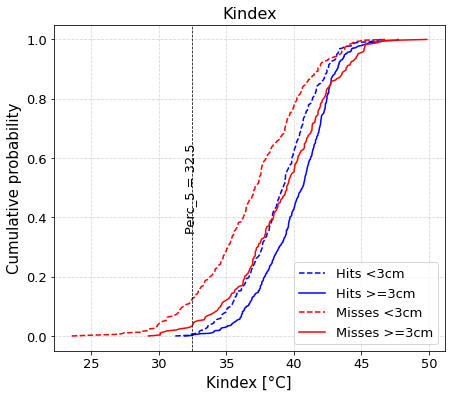

In [78]:
fig, ax = plt.subplots(figsize = (7,6))

data_Hitted_small = SPHERA_2016_2020_HITTED_wSize_noDupl_small[sp_par]
data_Hitted_large = SPHERA_2016_2020_HITTED_wSize_noDupl_large[sp_par]

data_Missed_small = SPHERA_2016_2020_MISSED_wSize_noDupl_small[sp_par]
data_Missed_large = SPHERA_2016_2020_MISSED_wSize_noDupl_large[sp_par]

#sort data
x_Hitted_small = np.sort(data_Hitted_small)
x_Hitted_large = np.sort(data_Hitted_large)
x_Missed_small = np.sort(data_Missed_small)
x_Missed_large = np.sort(data_Missed_large)

#calculate CDF values
y_Hitted_small = 1. * np.arange(len(data_Hitted_small)) / (len(data_Hitted_small) - 1)
y_Hitted_large = 1. * np.arange(len(data_Hitted_large)) / (len(data_Hitted_large) - 1)
y_Missed_small = 1. * np.arange(len(data_Missed_small)) / (len(data_Missed_small) - 1)
y_Missed_large = 1. * np.arange(len(data_Missed_large)) / (len(data_Missed_large) - 1)

#plot CDF
ax.plot(x_Hitted_small, y_Hitted_small, color='blue', ls='--', label='Hits <3cm')
ax.plot(x_Hitted_large, y_Hitted_large, color='blue', label='Hits >=3cm')

ax.plot(x_Missed_small, y_Missed_small, color='red', ls='--', label='Misses <3cm')
ax.plot(x_Missed_large, y_Missed_large, color='red', label='Misses >=3cm')

ax.set_xlabel(f'{sp_par} ' + f'{un_meas}', fontsize=15)
ax.set_ylabel('Cumulative probability', fontsize=15)
ax.set_title(f'{sp_par}', fontsize=16);

plt.axvline(x=thresh, lw=0.75, linestyle='--', color='black')

plt.text(thresh*(1-0.02), .5, f"Perc_{percent} = {thresh}", 
         rotation=90, verticalalignment='center', color='black', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--', alpha=0.5)
plt.legend(loc='best', fontsize=13)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/CDF_distributions_eswdValid/small-large_NODUPLICATES/CDF_{sp_par}.pdf', 
#            dpi=300, bbox_inches='tight')

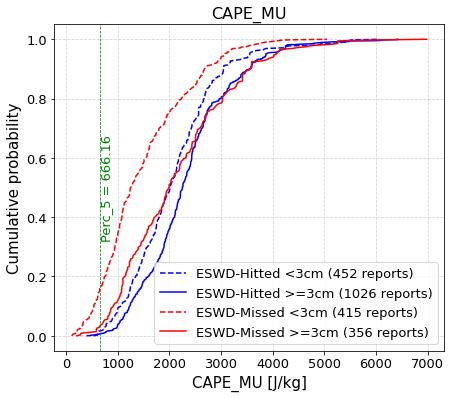

In [577]:
fig, ax = plt.subplots(figsize = (7,6))

data_Hitted_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[sp_par]
data_Hitted_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[sp_par]

data_Missed_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[sp_par]
data_Missed_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[sp_par]

#sort data
x_Hitted_small = np.sort(data_Hitted_small)
x_Hitted_large = np.sort(data_Hitted_large)
x_Missed_small = np.sort(data_Missed_small)
x_Missed_large = np.sort(data_Missed_large)

#calculate CDF values
y_Hitted_small = 1. * np.arange(len(data_Hitted_small)) / (len(data_Hitted_small) - 1)
y_Hitted_large = 1. * np.arange(len(data_Hitted_large)) / (len(data_Hitted_large) - 1)
y_Missed_small = 1. * np.arange(len(data_Missed_small)) / (len(data_Missed_small) - 1)
y_Missed_large = 1. * np.arange(len(data_Missed_large)) / (len(data_Missed_large) - 1)

#plot CDF
ax.plot(x_Hitted_small, y_Hitted_small, color='blue', ls='--', label='ESWD-Hitted <3cm (452 reports)')
ax.plot(x_Hitted_large, y_Hitted_large, color='blue', label='ESWD-Hitted >=3cm (1026 reports)')

ax.plot(x_Missed_small, y_Missed_small, color='red', ls='--', label='ESWD-Missed <3cm (415 reports)')
ax.plot(x_Missed_large, y_Missed_large, color='red', label='ESWD-Missed >=3cm (356 reports)')

ax.set_xlabel(f'{sp_par} ' + f'{un_meas}', fontsize=15)
ax.set_ylabel('Cumulative probability', fontsize=15)
ax.set_title(f'{sp_par}', fontsize=16);

plt.axvline(x=thresh, lw=0.75, linestyle='--', color='green')

plt.text(thresh*(1-0.02), .5, f"Perc_{percent} = {thresh}", 
         rotation=90, verticalalignment='center', color='green', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--', alpha=0.5)
plt.legend(loc='best', fontsize=13)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/CDF_distributions_eswdValid/CDF_{sp_par}.pdf', 
#            dpi=300, bbox_inches='tight')

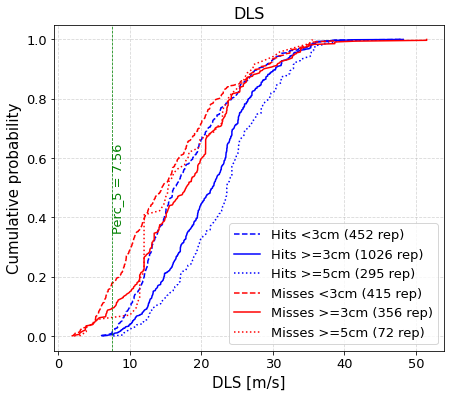

In [139]:
fig, ax = plt.subplots(figsize = (7,6))

data_Hitted_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[sp_par]
data_Hitted_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[sp_par]
data_Hitted_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_Verylarge[sp_par]

data_Missed_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[sp_par]
data_Missed_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[sp_par]
data_Missed_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_Verylarge[sp_par]

#sort data
x_Hitted_small = np.sort(data_Hitted_small)
x_Hitted_large = np.sort(data_Hitted_large)
x_Hitted_Verylarge = np.sort(data_Hitted_Verylarge)
x_Missed_small = np.sort(data_Missed_small)
x_Missed_large = np.sort(data_Missed_large)
x_Missed_Verylarge = np.sort(data_Missed_Verylarge)

#calculate CDF values
y_Hitted_small = 1. * np.arange(len(data_Hitted_small)) / (len(data_Hitted_small) - 1)
y_Hitted_large = 1. * np.arange(len(data_Hitted_large)) / (len(data_Hitted_large) - 1)
y_Hitted_Verylarge = 1. * np.arange(len(data_Hitted_Verylarge)) / (len(data_Hitted_Verylarge) - 1)
y_Missed_small = 1. * np.arange(len(data_Missed_small)) / (len(data_Missed_small) - 1)
y_Missed_large = 1. * np.arange(len(data_Missed_large)) / (len(data_Missed_large) - 1)
y_Missed_Verylarge = 1. * np.arange(len(data_Missed_Verylarge)) / (len(data_Missed_Verylarge) - 1)

#plot CDF
ax.plot(x_Hitted_small, y_Hitted_small, color='blue', ls='--', label='Hits <3cm (452 rep)')
ax.plot(x_Hitted_large, y_Hitted_large, color='blue', label='Hits >=3cm (1026 rep)')
ax.plot(x_Hitted_Verylarge, y_Hitted_Verylarge, color='blue', ls=':', label='Hits >=5cm (295 rep)')

ax.plot(x_Missed_small, y_Missed_small, color='red', ls='--', label='Misses <3cm (415 rep)')
ax.plot(x_Missed_large, y_Missed_large, color='red', label='Misses >=3cm (356 rep)')
ax.plot(x_Missed_Verylarge, y_Missed_Verylarge, color='red', ls=':', label='Misses >=5cm (72 rep)')

ax.set_xlabel(f'{sp_par} ' + f'{un_meas}', fontsize=15)
ax.set_ylabel('Cumulative probability', fontsize=15)
ax.set_title(f'{sp_par}', fontsize=16);

plt.axvline(x=thresh, lw=0.75, linestyle='--', color='green')

plt.text(thresh*(1-0.02), .5, f"Perc_{percent} = {thresh}", 
         rotation=90, verticalalignment='center', color='green', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--', alpha=0.5)
plt.legend(loc='best', fontsize=13)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/CDF_distributions_eswdValid/small-large-Verylarge/CDF_{sp_par}.pdf', 
#            dpi=300, bbox_inches='tight')

How many reports show ambient conditions falling below the thresholds imposed for hail presence (at least one parameter)?

In [47]:
SPHERA_Pred_HITTED_wSize = gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED.loc[filt_eswd_HITTED_2016_2020[filt_eswd_HITTED_2016_2020['size']>=0].index]
SPHERA_Pred_MISSED_wSize = gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED.loc[filt_eswd_MISSED_2016_2020[filt_eswd_MISSED_2016_2020['size']>=0].index]

In [76]:
SPHERA_Pred_HITTED_wSize_belowTHRESH = SPHERA_Pred_HITTED_wSize.loc[(SPHERA_Pred_HITTED_wSize['CAPE_MU'].values < t_CAPE) |
                                                                   (SPHERA_Pred_HITTED_wSize['DLS'].values < t_DLS) | 
                                                                   (SPHERA_Pred_HITTED_wSize['LI'].values > t_LI) |
                                                                   (SPHERA_Pred_HITTED_wSize['H0'].values > t_H0) |
                                                                   (SPHERA_Pred_HITTED_wSize['Kindex'].values < t_K)]
SPHERA_Pred_HITTED_wSize_belowTHRESH

,datetime_agg,box_id,%VV700,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML,geometry
121,2016-05-27 20:00:00,NaN,100.000000,34.129665,-2.081848,18.814158,3459.54419,612.200012,383.841675,None
122,2016-05-27 20:00:00,NaN,100.000000,34.129665,-2.081848,18.814158,3459.54419,612.200012,383.841675,None
123,2016-05-27 20:00:00,NaN,78.947365,34.427887,-2.081848,19.509832,3459.54419,612.200012,383.841675,None
135,2016-05-28 15:00:00,NaN,100.000000,37.375286,-2.933463,17.580893,3520.00830,639.337524,372.808319,None
143,2016-05-29 18:00:00,NaN,100.000000,39.054043,-2.420074,18.905088,3284.32495,628.616638,388.340637,None
...,...,...,...,...,...,...,...,...,...,...
2673,2020-08-16 19:00:00,NaN,100.000000,40.851486,-5.319835,7.256876,3609.80005,2296.733400,1613.775020,None
2674,2020-08-16 20:00:00,NaN,100.000000,40.851486,-0.771482,9.408002,3715.50000,1145.908330,303.812500,None
2738,2020-08-24 21:00:00,NaN,100.000000,38.734497,-1.965664,13.896248,3341.65845,990.900024,444.328949,None
2741,2020-08-24 22:00:00,NaN,100.000000,38.958576,-2.086704,13.896248,3325.56250,990.900024,322.802643,None


**Fraction of hit reports with at least 1 parameter falling in its filtered data range= 66/1478= 4.5%**

In [79]:
SPHERA_Pred_MISSED_wSize_belowTHRESH = SPHERA_Pred_MISSED_wSize.loc[(SPHERA_Pred_MISSED_wSize['CAPE_MU'].values < t_CAPE) |
                                                                   (SPHERA_Pred_MISSED_wSize['DLS'].values < t_DLS) | 
                                                                   (SPHERA_Pred_MISSED_wSize['LI'].values > t_LI) |
                                                                   (SPHERA_Pred_MISSED_wSize['H0'].values > t_H0) |
                                                                   (SPHERA_Pred_MISSED_wSize['Kindex'].values < t_K)]
SPHERA_Pred_MISSED_wSize_belowTHRESH

,datetime_agg,box_id,%VV700,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML,geometry
3,2016-04-08 04:00:00,NaN,93.333336,30.302052,7.663734,18.190380,2481.96094,174.648438,0.137500,None
5,2016-04-12 13:00:00,NaN,100.000000,31.579523,-1.976746,20.732588,1956.57812,532.982788,356.995300,None
7,2016-04-12 14:00:00,NaN,100.000000,27.422359,-0.005491,26.895628,2016.23071,326.243744,205.037506,None
10,2016-04-14 10:00:00,NaN,100.000000,34.436394,-2.121081,26.283789,2309.82495,643.174316,383.954041,None
13,2016-05-03 13:00:00,NaN,100.000000,29.840527,-0.656218,7.531402,1989.46094,486.857422,372.709961,None
...,...,...,...,...,...,...,...,...,...,...
2884,2020-09-16 15:00:00,NaN,100.000000,41.941860,-5.915679,3.808314,3566.58813,1879.675050,1508.041630,None
2885,2020-09-16 16:00:00,NaN,100.000000,38.884521,-5.924146,3.298394,3545.30835,1857.308350,1490.981200,None
2886,2020-09-16 18:00:00,NaN,100.000000,35.238720,-4.707013,3.938592,3598.59375,1408.599980,980.575012,None
2887,2020-09-16 22:00:00,NaN,68.421051,39.992565,-7.408572,5.155236,3682.07495,2579.333250,2228.533450,None


**Fraction of missed reports with at least 1 parameter falling in its filtered data range= 326/771= 42.3%**

## - 2D phase-space between SPHERA parameters

In [38]:
#aggregate Hitted/Missed events together:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED,
                                                 gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED])

In [39]:
gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL

,datetime_agg,box_id,%VV700,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML,geometry
24,2016-05-10 17:00:00,NaN,100.0,35.255409,-4.222092,20.094412,2765.12500,1211.79602,766.197388,None
25,2016-05-10 17:00:00,NaN,100.0,35.341953,-4.111314,20.094412,2765.12500,1211.79602,766.197388,None
33,2016-05-14 17:00:00,NaN,100.0,37.110119,-5.283839,13.240290,2557.78760,1482.65308,1002.045840,None
34,2016-05-14 17:00:00,NaN,100.0,37.398460,-5.313281,13.240290,2573.56885,1514.97913,1043.375000,None
35,2016-05-14 17:00:00,NaN,100.0,37.398460,-5.313281,13.240290,2573.56885,1514.97913,1043.375000,None
...,...,...,...,...,...,...,...,...,...,...
2894,2020-09-23 09:00:00,NaN,100.0,32.518288,-5.635742,19.806095,3288.28760,2143.85010,1940.081300,None
2904,2020-09-23 16:00:00,NaN,100.0,41.999920,-10.741594,28.833755,3686.30005,5053.58105,4337.143550,None
2906,2020-09-25 09:00:00,NaN,100.0,40.222080,-9.889549,29.235088,3186.79688,2998.01660,2563.237550,None
2938,2020-09-25 15:00:00,NaN,100.0,37.157112,-3.515975,22.782589,2896.57812,879.25000,746.227966,None


In [79]:
#setup bins for each parameter:
cape_bins = np.linspace(0, 7000, 20)
h0_bins = np.linspace(1300, 4600, 20)
dls_bins = np.linspace(0, 50, 20)
K_bins = np.linspace(25, 50, 20)
LI_bins = np.linspace(-15, 8, 20)

#### - All ESWD reports plots

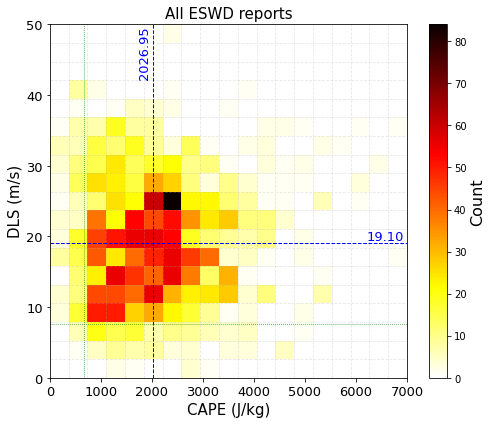

In [41]:
x_thresh = t_CAPE
y_thresh = t_DLS

fig, ax = plt.subplots(figsize =(8, 6.5))

ax.set_xticks(cape_bins, minor=True)
ax.set_yticks(dls_bins, minor=True)
# Creating plot
plt.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['CAPE_MU'], gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['DLS'],
          bins=[cape_bins,dls_bins], cmap='hot_r');
plt.colorbar().set_label(label='Count',size=16)
ax.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
ax.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

ax.axvline(x=np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['CAPE_MU']), lw=1, linestyle='--', color='blue')
ax.axhline(y=np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['DLS']), lw=1, linestyle='--', color='blue')

plt.text(np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['CAPE_MU'])-300, 46, 
         f"{np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['CAPE_MU']):.2f}", rotation=90, verticalalignment='center', 
         color='blue', fontsize=13)
plt.text(6200, np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['DLS']), 
         f"{np.mean(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL['DLS']):.2f}", rotation=0, verticalalignment='bottom', 
         color='blue', fontsize=13)

ax.grid(which='minor', alpha=0.3, ls='--')
plt.tick_params(axis='both', which='minor',bottom=False,left=False,labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('DLS (m/s)', fontsize=15)
ax.set_xlabel('CAPE (J/kg)', fontsize=15)
ax.set_title('All ESWD reports', fontsize=15);

#### - All ESWD + Hit/miss separation plots

In [42]:
#WRITE FUNCTIONS OF 2D HISTOGRAM PLOTS BY SELECTING TWO PARAMETERS:
#ALL-HIT-MISS histograms

def Hist2d_hitMiss(par_x,par_y):
    
    #parameters for different proxies:
    if par_x == 'LI':
        x_thresh = t_LI
        x_bins = LI_bins
        x_lab = 'SLI (°C)'
    elif par_x == 'Kindex':
        x_thresh = t_K
        x_bins = K_bins
        x_lab = 'K (°C)'
    elif par_x == 'CAPE_MU':
        x_thresh = t_CAPE
        x_bins = cape_bins
        x_lab = 'CAPE (J/kg)'
    elif par_x == 'H0':
        x_thresh = t_H0
        x_bins = h0_bins
        x_lab = 'H0 (m)'
    elif par_x == 'DLS':
        x_thresh = t_DLS
        x_bins = dls_bins
        x_lab = 'DLS (m/s)'

    if par_y == 'LI':
        y_thresh = t_LI
        y_bins = LI_bins
        y_lab = 'SLI (°C)'
    elif par_y == 'Kindex':
        y_thresh = t_K
        y_bins = K_bins
        y_lab = 'K (°C)'
    elif par_y == 'CAPE_MU':
        y_thresh = t_CAPE
        y_bins = cape_bins
        y_lab = 'CAPE (J/kg)'
    elif par_y == 'H0':
        y_thresh = t_H0
        y_bins = h0_bins
        y_lab = 'H0 (m)'
    elif par_y == 'DLS':
        y_thresh = t_DLS
        y_bins = dls_bins
        y_lab = 'DLS (m/s)'
    
    #2d HISTOGRAMS SEPARATING BETWEEN ALL, HITTED AND MISSED ESWD REPORTS

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,6))

    hist1 = ax1.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x], gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y],
              bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=70);
    plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
    ax1.grid(which='minor', alpha=0.3, ls='--')
    ax1.set_xticks(x_bins, minor=True)
    ax1.set_yticks(y_bins, minor=True)
    ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax2.tick_params(labelsize=13)
    ax1.set_ylabel(y_lab, fontsize=15)
    ax1.set_xlabel(x_lab, fontsize=15)
    ax1.set_title('All ESWD reports', fontsize=15);
    ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
    ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

    #plot median lines
    ax1.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x]), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y]), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x]), y_bins[-3], 
         f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y]), 
             f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax1.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x], 25), y_bins[-3], 
         f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x],25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 25), 
             f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax1.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x], 75), y_bins[-3], 
         f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_x],75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 75), 
             f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_ALL[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    

    hist2 = ax2.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y],
              bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=70);
    plt.colorbar(hist2[3], ax=ax2).set_label(label='Count',size=16)
    ax2.grid(which='minor', alpha=0.3, ls='--')
    ax2.set_xticks(x_bins, minor=True)
    ax2.set_yticks(y_bins, minor=True)
    ax2.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax2.tick_params(labelsize=12)
    ax2.set_ylabel(y_lab, fontsize=15)
    ax2.set_xlabel(x_lab, fontsize=15)
    ax2.set_title('Hitted ESWD reports', fontsize=15);
    ax2.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
    ax2.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')
    
    #plot median lines
    ax2.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x]), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y]), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x]), y_bins[-3], 
         f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y]), 
             f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax2.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 25), y_bins[-3], 
         f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 25), 
             f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax2.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 75), y_bins[-3], 
         f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_x], 75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 75), 
             f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
        
    
    
    hist3 = ax3.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y],
              bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=70);
    plt.colorbar(hist3[3], ax=ax3).set_label(label='Count',size=16)
    ax3.grid(which='minor', alpha=0.3, ls='--')
    ax3.set_xticks(x_bins, minor=True)
    ax3.set_yticks(y_bins, minor=True)
    ax3.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax3.tick_params(labelsize=12)
    ax3.set_ylabel(y_lab, fontsize=15)
    ax3.set_xlabel(x_lab, fontsize=15)
    ax3.set_title('Missed ESWD reports', fontsize=15);
    ax3.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
    ax3.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')
    
    #plot median lines
    ax3.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x]), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y]), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x]), y_bins[-3], 
         f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y]), 
             f"p50={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax3.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 25), y_bins[-3], 
         f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 25), 
             f"p25={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax3.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 75), y_bins[-3], 
         f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_x], 75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 75), 
             f"p75={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)

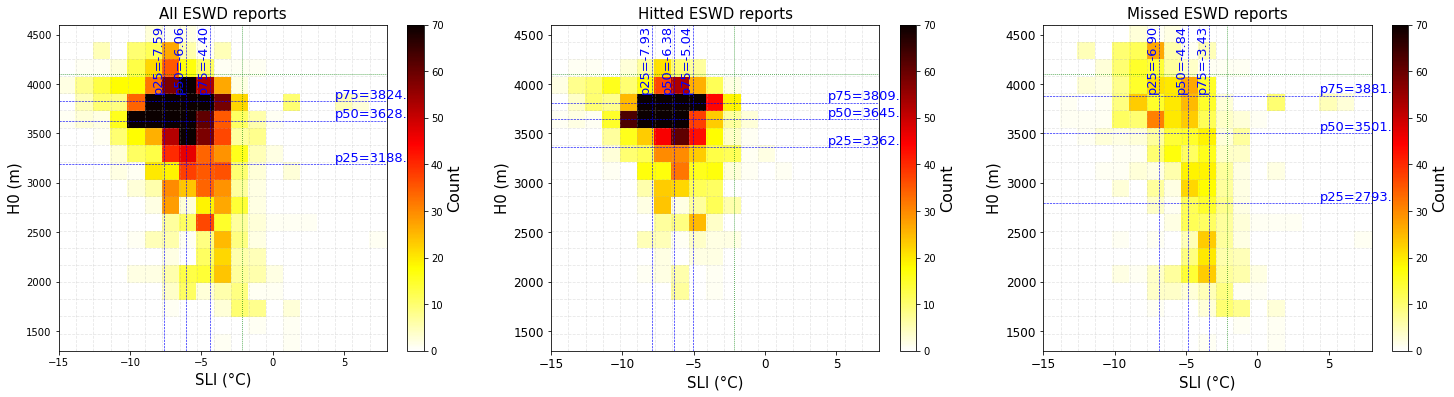

In [70]:
par_x = 'LI'
par_y = 'H0'

Hist2d_hitMiss(par_x,par_y)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/2dHistograms/hitMiss_2dHist_{par_x}_{par_y}.pdf', 
#            dpi=300, bbox_inches='tight')

#### - Hit/miss small/large hail separations

In [96]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [101]:
#WRITE FUNCTIONS OF 2D HISTOGRAM PLOTS BY SELECTING TWO PARAMETERS:
#HIT-MISS and LARGE-SMALL hail histograms
def Hist2d_LargeSmallHail_hitMiss(par_x,par_y,
                                  gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large,
                                  gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small,
                                  gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large,
                                  gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small):
    
    #parameters for different proxies:
    if par_x == 'LI':
        x_thresh = t_LI
        x_bins = LI_bins
        x_lab = 'SLI (°C)'
    elif par_x == 'Kindex':
        x_thresh = t_K
        x_bins = K_bins
        x_lab = 'K index (°C)'
    elif par_x == 'CAPE_MU':
        x_thresh = t_CAPE
        x_bins = cape_bins
        x_lab = 'CAPE (J/kg)'
    elif par_x == 'H0':
        x_thresh = t_H0
        x_bins = h0_bins
        x_lab = 'H0 (m)'
    elif par_x == 'DLS':
        x_thresh = t_DLS
        x_bins = dls_bins
        x_lab = 'DLS (m/s)'

    if par_y == 'LI':
        y_thresh = t_LI
        y_bins = LI_bins
        y_lab = 'SLI (°C)'
    elif par_y == 'Kindex':
        y_thresh = t_K
        y_bins = K_bins
        y_lab = 'K index (°C)'
    elif par_y == 'CAPE_MU':
        y_thresh = t_CAPE
        y_bins = cape_bins
        y_lab = 'CAPE (J/kg)'
    elif par_y == 'H0':
        y_thresh = t_H0
        y_bins = h0_bins
        y_lab = 'H0 (m)'
    elif par_y == 'DLS':
        y_thresh = t_DLS
        y_bins = dls_bins
        y_lab = 'DLS (m/s)'
    
    #2d HISTOGRAMS SEPARATING BETWEEN HITTED AND MISSED and LARGE AND SMALL HAIL ESWD REPORTS

    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(14,12))
    
    hist1 = ax1.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x], 
                       gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y],
                       bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=35);
    plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
    ax1.grid(which='minor', alpha=0.3, ls='--')
    ax1.set_xticks(x_bins, minor=True)
    ax1.set_yticks(y_bins, minor=True)
    ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax2.tick_params(labelsize=13)
    ax1.set_ylabel(y_lab, fontsize=15)
    ax1.set_xlabel(x_lab, fontsize=15)
    ax1.set_title(f'Hits - Large hail', fontsize=15); #({len(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large)} rep)
    ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='black')
    ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='black')
    
    #plot median lines
    ax1.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x]), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y]), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x]), y_bins[-3], 
         '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y]), 
             '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax1.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x], 25), y_bins[-3], 
         '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x],25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 25), 
             '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax1.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax1.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax1.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x], 75), y_bins[-3], 
         '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_x],75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax1.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 75), 
             '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_large[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    


    hist2 = ax2.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 
                       gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y],
                       bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=35);
    plt.colorbar(hist2[3], ax=ax2).set_label(label='Count',size=16)
    ax2.grid(which='minor', alpha=0.3, ls='--')
    ax2.set_xticks(x_bins, minor=True)
    ax2.set_yticks(y_bins, minor=True)
    ax2.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax2.tick_params(labelsize=12)
    ax2.set_ylabel(y_lab, fontsize=15)
    ax2.set_xlabel(x_lab, fontsize=15)
    ax2.set_title(f'Hits - Small hail', fontsize=15); # ({len(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small)} rep)
    ax2.axvline(x=x_thresh, lw=0.75, linestyle=':', color='black')
    ax2.axhline(y=y_thresh, lw=0.75, linestyle=':', color='black')
    
    #plot median lines
    ax2.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x]), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y]), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x]), y_bins[-3], 
         '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y]), 
             '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax2.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 25), y_bins[-3], 
         '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 25), 
             '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax2.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax2.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax2.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 75), y_bins[-3], 
         '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_x], 75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax2.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 75), 
             '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_HITTED_small[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)


    hist3 = ax3.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 
                       gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y],
                       bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=35);
    plt.colorbar(hist3[3], ax=ax3).set_label(label='Count',size=16)
    ax3.grid(which='minor', alpha=0.3, ls='--')
    ax3.set_xticks(x_bins, minor=True)
    ax3.set_yticks(y_bins, minor=True)
    ax3.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax3.tick_params(labelsize=12)
    ax3.set_ylabel(y_lab, fontsize=15)
    ax3.set_xlabel(x_lab, fontsize=15)
    ax3.set_title(f'Misses - Large hail', fontsize=15);# ({len(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large)} rep)
    ax3.axvline(x=x_thresh, lw=0.75, linestyle=':', color='black')
    ax3.axhline(y=y_thresh, lw=0.75, linestyle=':', color='black')

    #plot median lines
    ax3.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x]), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y]), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x]), y_bins[-3], 
         '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y]), 
             '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax3.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 25), y_bins[-3], 
         '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 25), 
             '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax3.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax3.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax3.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 75), y_bins[-3], 
         '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_x], 75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax3.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 75), 
             '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_large[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)


    hist4 = ax4.hist2d(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 
                       gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y],
                       bins=[x_bins,y_bins], cmap='hot_r', vmin=0, vmax=35);
    plt.colorbar(hist4[3], ax=ax4).set_label(label='Count',size=16)
    ax4.grid(which='minor', alpha=0.3, ls='--')
    ax4.set_xticks(x_bins, minor=True)
    ax4.set_yticks(y_bins, minor=True)
    ax4.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
    ax4.tick_params(labelsize=12)
    ax4.set_ylabel(y_lab, fontsize=15)
    ax4.set_xlabel(x_lab, fontsize=15)
    ax4.set_title(f'Misses - Small hail', fontsize=15); # ({len(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small)} rep)
    ax4.axvline(x=x_thresh, lw=0.75, linestyle=':', color='black')
    ax4.axhline(y=y_thresh, lw=0.75, linestyle=':', color='black')
    
    #plot median lines
    ax4.axvline(x=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x]), lw=0.6, linestyle='--', color='blue')
    ax4.axhline(y=np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y]), lw=0.6, linestyle='--', color='blue')
    ax4.text(np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x]), y_bins[-3], 
         '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x]):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax4.text(x_bins[-4], np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y]), 
             '$p_{50}$'+f"={np.median(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y]):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 25th percentile lines
    ax4.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 25), lw=0.6, linestyle='--', color='blue')
    ax4.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 25), lw=0.6, linestyle='--', color='blue')
    ax4.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 25), y_bins[-3], 
         '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 25):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax4.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 25), 
             '$p_{25}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 25):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)
    
    #plot 75th percentile lines
    ax4.axvline(x=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 75), lw=0.6, linestyle='--', color='blue')
    ax4.axhline(y=np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 75), lw=0.6, linestyle='--', color='blue')
    ax4.text(np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 75), y_bins[-3], 
         '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_x], 75):.2f}", rotation=90,  ha='right', va='center', 
         color='blue', fontsize=13)
    ax4.text(x_bins[-4], np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 75), 
             '$p_{75}$'+f"={np.percentile(gdf_sp_3ESWDh_nn_Aggr_2016_2020_MISSED_small[par_y], 75):.2f}", rotation=0, va='bottom', 
             color='blue', fontsize=13)

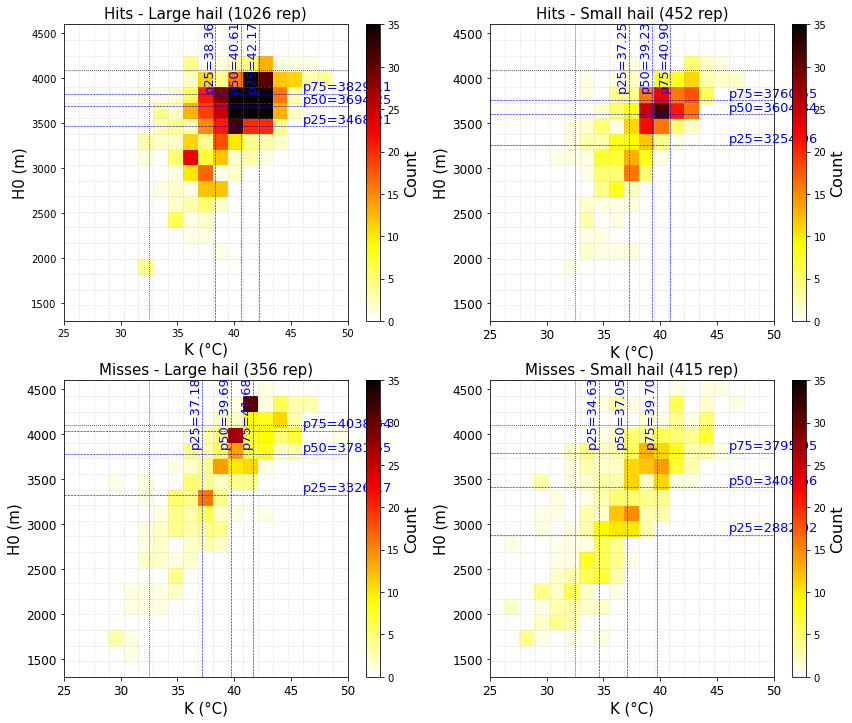

In [92]:
par_x = 'Kindex'
par_y = 'H0'

Hist2d_LargeSmallHail_hitMiss(par_x,par_y)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/2dHistograms/LargeSmall_hitMiss_2dHist_{par_x}_{par_y}_IQR.pdf', 
#            dpi=200, bbox_inches='tight')

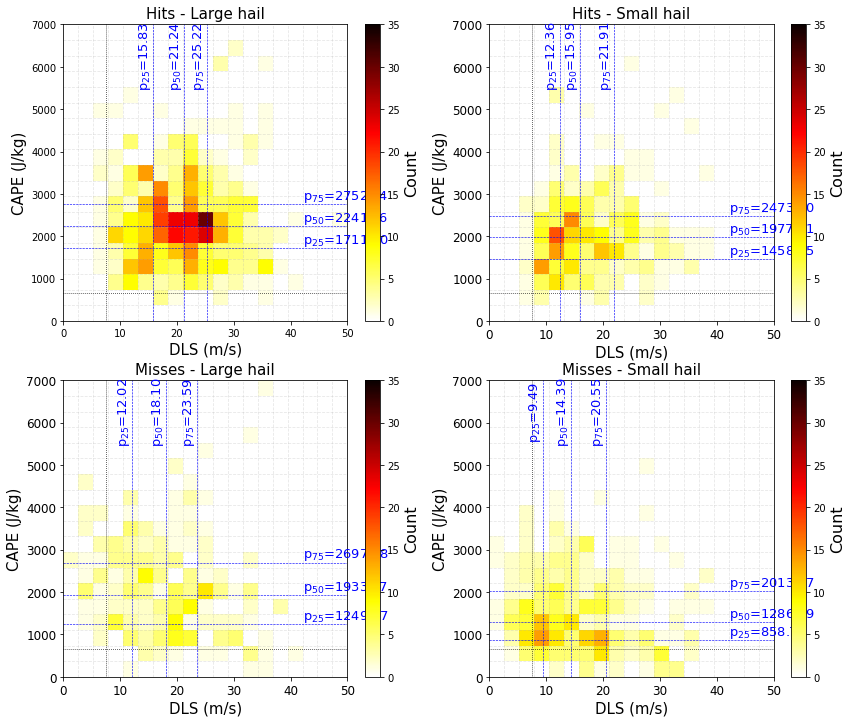

In [104]:
par_x = 'DLS'
par_y = 'CAPE_MU'

Hist2d_LargeSmallHail_hitMiss(par_x,par_y,HITTED_wSize_noDuplic_large, HITTED_wSize_noDuplic_small,
                             MISSED_wSize_noDuplic_large,MISSED_wSize_noDuplic_small)

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/2dHistograms/dropped_duplicates/LargeSmall_hitMiss_2dHist_{par_x}_{par_y}_IQR.svg', 
#            dpi=200, bbox_inches='tight')

## 5.2) IRBMIN and DTmin observed cloud-top temperature characterization

Independently from OTprobability (not >0)

In [15]:
#DEFINE LIST OF DAYS WITH JULIAN DAY AND DATETIME FORMAT:

#days in 2016: 214 days (actually 211 because the following days are missing: 2016185,2016186,2016201 )
days_2016 = [2016092,2016093,2016094,2016095,2016096,2016097,2016098,2016099,2016100,2016101,2016102,2016103,2016104,
        2016105,2016106,2016107,2016108,2016109,2016110,2016111,2016112,2016113,2016114,2016115,2016116,2016117,
        2016118,2016119,2016120,2016121,2016122,2016123,2016124,2016125,2016126,2016127,2016128,2016129,2016130,
        2016131,2016132,2016133,2016134,2016135,2016136,2016137,2016138,2016139,2016140,2016141,2016142,2016143,
        2016144,2016145,2016146,2016147,2016148,2016149,2016150,2016151,2016152,2016153,2016154,2016155,2016156,
        2016157,2016158,2016159,2016160,2016161,2016162,2016163,2016164,2016165,2016166,2016167,2016168,2016169,
        2016170,2016171,2016172,2016173,2016174,2016175,2016176,2016177,2016178,2016179,2016180,2016181,2016182,
        2016183,2016184,2016185,2016186,2016187,2016188,2016189,2016190,2016191,2016192,2016193,2016194,2016195,
        2016196,2016197,2016198,2016199,2016200,2016201,2016202,2016203,2016204,2016205,2016206,2016207,2016208,
        2016209,2016210,2016211,2016212,2016213,2016214,2016215,2016216,2016217,2016218,2016219,2016220,2016221,
        2016222,2016223,2016224,2016225,2016226,2016227,2016228,2016229,2016230,2016231,2016232,2016233,2016234,
        2016235,2016236,2016237,2016238,2016239,2016240,2016241,2016242,2016243,2016244,2016245,2016246,2016247,
        2016248,2016249,2016250,2016251,2016252,2016253,2016254,2016255,2016256,2016257,2016258,2016259,2016260,
        2016261,2016262,2016263,2016264,2016265,2016266,2016267,2016268,2016269,2016270,2016271,2016272,2016273,
        2016274,2016275,2016276,2016277,2016278,2016279,2016280,2016281,2016282,2016283,2016284,2016285,2016286,
        2016287,2016288,2016289,2016290,2016291,2016292,2016293,2016294,2016295,2016296,2016297,2016298,2016299,
        2016300,2016301,2016302,2016303,2016304,2016305]

#days in 2017: missing 1 april (2017091), 213 days
days_2017 = [2017091,2017092,2017093,2017094,2017095,2017096,2017097,2017098,2017099,2017100,2017101,2017102,2017103,2017104,
        2017105,2017106,2017107,2017108,2017109,2017110,2017111,2017112,2017113,2017114,2017115,2017116,2017117,
        2017118,2017119,2017120,2017121,2017122,2017123,2017124,2017125,2017126,2017127,2017128,2017129,2017130,
        2017131,2017132,2017133,2017134,2017135,2017136,2017137,2017138,2017139,2017140,2017141,2017142,2017143,
        2017144,2017145,2017146,2017147,2017148,2017149,2017150,2017151,2017152,2017153,2017154,2017155,2017156,
        2017157,2017158,2017159,2017160,2017161,2017162,2017163,2017164,2017165,2017166,2017167,2017168,2017169,
        2017170,2017171,2017172,2017173,2017174,2017175,2017176,2017177,2017178,2017179,2017180,2017181,2017182,
        2017183,2017184,2017185,2017186,2017187,2017188,2017189,2017190,2017191,2017192,2017193,2017194,2017195,
        2017196,2017197,2017198,2017199,2017200,2017201,2017202,2017203,2017204,2017205,2017206,2017207,2017208,
        2017209,2017210,2017211,2017212,2017213,2017214,2017215,2017216,2017217,2017218,2017219,2017220,2017221,
        2017222,2017223,2017224,2017225,2017226,2017227,2017228,2017229,2017230,2017231,2017232,2017233,2017234,
        2017235,2017236,2017237,2017238,2017239,2017240,2017241,2017242,2017243,2017244,2017245,2017246,2017247,
        2017248,2017249,2017250,2017251,2017252,2017253,2017254,2017255,2017256,2017257,2017258,2017259,2017260,
        2017261,2017262,2017263,2017264,2017265,2017266,2017267,2017268,2017269,2017270,2017271,2017272,2017273,
        2017274,2017275,2017276,2017277,2017278,2017279,2017280,2017281,2017282,2017283,2017284,2017285,2017286,
        2017287,2017288,2017289,2017290,2017291,2017292,2017293,2017294,2017295,2017296,2017297,2017298,2017299,
        2017300,2017301,2017302,2017303,2017304]

#days in 2018: missing 1 april (2018091) and 17 june (2018168), 212 days
days_2018 = [2018091,2018092,2018093,2018094,2018095,2018096,2018097,2018098,2018099,2018100,2018101,2018102,2018103,2018104,
        2018105,2018106,2018107,2018108,2018109,2018110,2018111,2018112,2018113,2018114,2018115,2018116,2018117,
        2018118,2018119,2018120,2018121,2018122,2018123,2018124,2018125,2018126,2018127,2018128,2018129,2018130,
        2018131,2018132,2018133,2018134,2018135,2018136,2018137,2018138,2018139,2018140,2018141,2018142,2018143,
        2018144,2018145,2018146,2018147,2018148,2018149,2018150,2018151,2018152,2018153,2018154,2018155,2018156,
        2018157,2018158,2018159,2018160,2018161,2018162,2018163,2018164,2018165,2018166,2018167,2018168,2018169,
        2018170,2018171,2018172,2018173,2018174,2018175,2018176,2018177,2018178,2018179,2018180,2018181,2018182,
        2018183,2018184,2018185,2018186,2018187,2018188,2018189,2018190,2018191,2018192,2018193,2018194,2018195,
        2018196,2018197,2018198,2018199,2018200,2018201,2018202,2018203,2018204,2018205,2018206,2018207,2018208,
        2018209,2018210,2018211,2018212,2018213,2018214,2018215,2018216,2018217,2018218,2018219,2018220,2018221,
        2018222,2018223,2018224,2018225,2018226,2018227,2018228,2018229,2018230,2018231,2018232,2018233,2018234,
        2018235,2018236,2018237,2018238,2018239,2018240,2018241,2018242,2018243,2018244,2018245,2018246,2018247,
        2018248,2018249,2018250,2018251,2018252,2018253,2018254,2018255,2018256,2018257,2018258,2018259,2018260,
        2018261,2018262,2018263,2018264,2018265,2018266,2018267,2018268,2018269,2018270,2018271,2018272,2018273,
        2018274,2018275,2018276,2018277,2018278,2018279,2018280,2018281,2018282,2018283,2018284,2018285,2018286,
        2018287,2018288,2018289,2018290,2018291,2018292,2018293,2018294,2018295,2018296,2018297,2018298,2018299,
        2018300,2018301,2018302,2018303,2018304]

days_2019 = [2019091,2019092,2019093,2019094,2019095,2019096,2019097,2019098,2019099,2019100,2019101,2019102,2019103,2019104,
        2019105,2019106,2019107,2019108,2019109,2019110,2019111,2019112,2019113,2019114,2019115,2019116,2019117,
        2019118,2019119,2019120,2019121,2019122,2019123,2019124,2019125,2019126,2019127,2019128,2019129,2019130,
        2019131,2019132,2019133,2019134,2019135,2019136,2019137,2019138,2019139,2019140,2019141,2019142,2019143,
        2019144,2019145,2019146,2019147,2019148,2019149,2019150,2019151,2019152,2019153,2019154,2019155,2019156,
        2019157,2019158,2019159,2019160,2019161,2019162,2019163,2019164,2019165,2019166,2019167,2019168,2019169,
        2019170,2019171,2019172,2019173,2019174,2019175,2019176,2019177,2019178,2019179,2019180,2019181,2019182,
        2019183,2019184,2019185,2019186,2019187,2019188,2019189,2019190,2019191,2019192,2019193,2019194,2019195,
        2019196,2019197,2019198,2019199,2019200,2019201,2019202,2019203,2019204,2019205,2019206,2019207,2019208,
        2019209,2019210,2019211,2019212,2019213,2019214,2019215,2019216,2019217,2019218,2019219,2019220,2019221,
        2019222,2019223,2019224,2019225,2019226,2019227,2019228,2019229,2019230,2019231,2019232,2019233,2019234,
        2019235,2019236,2019237,2019238,2019239,2019240,2019241,2019242,2019243,2019244,2019245,2019246,2019247,
        2019248,2019249,2019250,2019251,2019252,2019253,2019254,2019255,2019256,2019257,2019258,2019259,2019260,
        2019261,2019262,2019263,2019264,2019265,2019266,2019267,2019268,2019269,2019270,2019271,2019272,2019273,
        2019274,2019275,2019276,2019277,2019278,2019279,2019280,2019281,2019282,2019283,2019284,2019285,2019286,
        2019287,2019288,2019289,2019290,2019291,2019292,2019293,2019294,2019295,2019296,2019297,2019298,2019299,
        2019300,2019301,2019302,2019303,2019304]

days_2020 = [2020092,2020093,2020094,2020095,2020096,2020097,2020098,2020099,2020100,2020101,2020102,2020103,2020104,
        2020105,2020106,2020107,2020108,2020109,2020110,2020111,2020112,2020113,2020114,2020115,2020116,2020117,
        2020118,2020119,2020120,2020121,2020122,2020123,2020124,2020125,2020126,2020127,2020128,2020129,2020130,
        2020131,2020132,2020133,2020134,2020135,2020136,2020137,2020138,2020139,2020140,2020141,2020142,2020143,
        2020144,2020145,2020146,2020147,2020148,2020149,2020150,2020151,2020152,2020153,2020154,2020155,2020156,
        2020157,2020158,2020159,2020160,2020161,2020162,2020163,2020164,2020165,2020166,2020167,2020168,2020169,
        2020170,2020171,2020172,2020173,2020174,2020175,2020176,2020177,2020178,2020179,2020180,2020181,2020182,
        2020183,2020184,2020185,2020186,2020187,2020188,2020189,2020190,2020191,2020192,2020193,2020194,2020195,
        2020196,2020197,2020198,2020199,2020200,2020201,2020202,2020203,2020204,2020205,2020206,2020207,2020208,
        2020209,2020210,2020211,2020212,2020213,2020214,2020215,2020216,2020217,2020218,2020219,2020220,2020221,
        2020222,2020223,2020224,2020225,2020226,2020227,2020228,2020229,2020230,2020231,2020232,2020233,2020234,
        2020235,2020236,2020237,2020238,2020239,2020240,2020241,2020242,2020243,2020244,2020245,2020246,2020247,
        2020248,2020249,2020250,2020251,2020252,2020253,2020254,2020255,2020256,2020257,2020258,2020259,2020260,
        2020261,2020262,2020263,2020264,2020265,2020266,2020267,2020268,2020269,2020270,2020271,2020272,2020273,
        2020274,2020275,2020276,2020277,2020278,2020279,2020280,2020281,2020282,2020283,2020284,2020285,2020286,
        2020287,2020288,2020289,2020290,2020291,2020292,2020293,2020294,2020295,2020296,2020297,2020298,2020299,
        2020300,2020301,2020302,2020303,2020304,2020305]

#write dataframes storing julian days and datetimes of OT days:

days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])
days_2019_df =pd.DataFrame(index=np.arange(0,len(days_2019),1), columns=['day','dtime'])
days_2020_df =pd.DataFrame(index=np.arange(0,len(days_2020),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime
    
for day,ind in zip(days_2019,np.arange(0,len(days_2019),1)):
    
    dtime = datetime.datetime.strptime('2019-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2019_df.iloc[ind]['day'] = day
    days_2019_df.iloc[ind]['dtime'] = dtime   
    
for day,ind in zip(days_2020,np.arange(0,len(days_2020),1)):
    
    dtime = datetime.datetime.strptime('2020-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2020_df.iloc[ind]['day'] = day
    days_2020_df.iloc[ind]['dtime'] = dtime   

days_2016_df.dtime = pd.to_datetime(days_2016_df.dtime)
days_2017_df.dtime = pd.to_datetime(days_2017_df.dtime)
days_2018_df.dtime = pd.to_datetime(days_2018_df.dtime)
days_2019_df.dtime = pd.to_datetime(days_2019_df.dtime)
days_2020_df.dtime = pd.to_datetime(days_2020_df.dtime)


#REMOVE MISSING DAYS (after creating dataframes otherwise day and dtime are shifted and wrong!!!)

#-2016: 2016185,2016186,2016201
days_2016_df = days_2016_df[(days_2016_df.day !=2016185) & (days_2016_df.day !=2016186) & 
                            (days_2016_df.day !=2016201)]
#-2017: 2017091 
days_2017_df = days_2017_df[days_2017_df.day != 2017091]

#-2018: 2018091, 2018168
days_2018_df = days_2018_df[(days_2018_df.day != 2018091) & (days_2018_df.day != 2018168)]

#-2019:

#-2020:
days_2020_df = days_2020_df[days_2020_df.day != 2020092]

In [16]:
#Find out the days containing at least 1 ESWD HITTED event
day_2016_wHitted_evs_df = days_2016_df[days_2016_df.dtime.isin(filt_eswd_HITTED_2016.datetime.dt.strftime("%Y-%m-%d"))]
day_2017_wHitted_evs_df = days_2017_df[days_2017_df.dtime.isin(filt_eswd_HITTED_2017.datetime.dt.strftime("%Y-%m-%d"))]
day_2018_wHitted_evs_df = days_2018_df[days_2018_df.dtime.isin(filt_eswd_HITTED_2018.datetime.dt.strftime("%Y-%m-%d"))]
day_2019_wHitted_evs_df = days_2019_df[days_2019_df.dtime.isin(filt_eswd_HITTED_2019.datetime.dt.strftime("%Y-%m-%d"))]
day_2020_wHitted_evs_df = days_2020_df[days_2020_df.dtime.isin(filt_eswd_HITTED_2020.datetime.dt.strftime("%Y-%m-%d"))]

day_wHitted_evs_df = dict()
day_wHitted_evs_df[2016] = day_2016_wHitted_evs_df
day_wHitted_evs_df[2017] = day_2017_wHitted_evs_df
day_wHitted_evs_df[2018] = day_2018_wHitted_evs_df
day_wHitted_evs_df[2019] = day_2019_wHitted_evs_df
day_wHitted_evs_df[2020] = day_2020_wHitted_evs_df

#Find out the days containing at least 1 ESWD MISSED event
day_2016_wMissed_evs_df = days_2016_df[days_2016_df.dtime.isin(filt_eswd_MISSED_2016.datetime.dt.strftime("%Y-%m-%d"))]
day_2017_wMissed_evs_df = days_2017_df[days_2017_df.dtime.isin(filt_eswd_MISSED_2017.datetime.dt.strftime("%Y-%m-%d"))]
day_2018_wMissed_evs_df = days_2018_df[days_2018_df.dtime.isin(filt_eswd_MISSED_2018.datetime.dt.strftime("%Y-%m-%d"))]
day_2019_wMissed_evs_df = days_2019_df[days_2019_df.dtime.isin(filt_eswd_MISSED_2019.datetime.dt.strftime("%Y-%m-%d"))]
day_2020_wMissed_evs_df = days_2020_df[days_2020_df.dtime.isin(filt_eswd_MISSED_2020.datetime.dt.strftime("%Y-%m-%d"))]

day_wMissed_evs_df = dict()
day_wMissed_evs_df[2016] = day_2016_wMissed_evs_df
day_wMissed_evs_df[2017] = day_2017_wMissed_evs_df
day_wMissed_evs_df[2018] = day_2018_wMissed_evs_df
day_wMissed_evs_df[2019] = day_2019_wMissed_evs_df
day_wMissed_evs_df[2020] = day_2020_wMissed_evs_df

#### - Read original NetCDF OT data and write .txt files for each day (as single geodataframe and not dict!) where data are aggregated hourly (i.e. 4 15-min steps for each hour)

In [17]:
year=2016

hhmin=0
hhmax=23

In [18]:
day_wHitted_evs_df[year]

,day,dtime
39,2016131,2016-05-10
43,2016135,2016-05-14
56,2016148,2016-05-27
57,2016149,2016-05-28
58,2016150,2016-05-29
64,2016156,2016-06-04
68,2016160,2016-06-08
73,2016165,2016-06-13
74,2016166,2016-06-14
76,2016168,2016-06-16


In [19]:
day_wHitted_evs_df[year].index[:]

Int64Index([ 39,  43,  56,  57,  58,  64,  68,  73,  74,  76,  78,  79,  83,
             85,  86,  87,  90,  92,  95, 101, 102, 103, 111, 112, 113, 117,
            120, 121, 126, 131, 136, 141, 142, 149, 150, 156, 165, 166, 197],
           dtype='int64')

In [49]:
###### Loop on days:
for d_ind in day_wHitted_evs_df[year].index[10:]: #day_wMissed_evs_df[year][14]:#.index[14]:

    start_time = time.time()

    day = day_wHitted_evs_df[year]['day'][d_ind]
    dtime = day_wHitted_evs_df[year]['dtime'][d_ind]

    #OT params:
    if dtime.year in [2018,2019,2020]:
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018 2019 2020

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = gpd.GeoDataFrame()

    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')
    
    
    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')

        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing, irbmin, ot_anvil_btdmin = HF.HF_OTdata(day,hh,hh+1,otpref,
                                                                                         otdir,othstart,
                                                                                         otpmax05=False)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing,dtmin,irbmin,ot_anvil_btdmin,otpmax_nonNull=False)

        if len(gdf_OT) == 0:
            continue
        else:
            dORIG_gdf_OT_daily = dORIG_gdf_OT_daily.append(gdf_OT)
    
    #write dictionary of filtered/unfiltered OTs to external file
    print('WRITE EXTERNAL FILE')
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin_OTanvilBTD/otpmax_all_onlyHITTEDeswd/{year}/OT_{day}.txt', 'wb') as file:
         pickle.dump(dORIG_gdf_OT_daily,file)

78 2016170 2016-06-18 00:00:00 Time: 0.006204366683959961
hour = 0
step1 - read OTs. Time: 0.9752705097198486
hour = 1
step1 - read OTs. Time: 4.430551290512085
hour = 2
step1 - read OTs. Time: 8.111045598983765
hour = 3
step1 - read OTs. Time: 11.77949070930481
hour = 4
step1 - read OTs. Time: 15.347612619400024
hour = 5
step1 - read OTs. Time: 19.55703091621399
hour = 6
step1 - read OTs. Time: 23.87187385559082
hour = 7
step1 - read OTs. Time: 28.29700207710266
hour = 8
step1 - read OTs. Time: 33.04387950897217
hour = 9
step1 - read OTs. Time: 38.725379943847656
hour = 10
step1 - read OTs. Time: 43.53127312660217
hour = 11
step1 - read OTs. Time: 48.814884185791016
hour = 12
step1 - read OTs. Time: 54.077919244766235
hour = 13
step1 - read OTs. Time: 59.723315715789795
hour = 14
step1 - read OTs. Time: 66.64109539985657
hour = 15
step1 - read OTs. Time: 71.17974734306335
hour = 16
step1 - read OTs. Time: 76.03067398071289
hour = 17
step1 - read OTs. Time: 80.11005425453186
hour = 18


KeyboardInterrupt: 

In [21]:
with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin_OTanvilBTD/otpmax_all_onlyHITTEDeswd/{year}/OT_2016170_SBAGLIATO.txt', "rb") as file:  
     OT_df = pickle.load(file)

In [34]:
xr_OT = xr.Dataset(data_vars=None, 
                   coords=dict(
                       lon=(["xlon", "xlat"], cpclon),
                       lat=(["xlon", "xlat"], cpclat),
                       time=ot_timing[0],
                   ),
                   attrs=dict(
                   description="OT max probability over SPHERA domain accumulated over the hour indicated in time",
                   units="%",
               ),
)

#set attributes of xr dataset:
xr_OT["lon"].attrs["long_name"] = "longitude"
xr_OT["lon"].attrs["units"] = "degree_east"
xr_OT["lon"].attrs["axis"] = "X"
xr_OT["lat"].attrs["long_name"] = "latitude"
xr_OT["lat"].attrs["units"] = "degree_north"
xr_OT["lat"].attrs["axis"] = "Y"

#Trick: set otpmax variable starting from lat array:
xr_OT['otpmax'] = xr_OT.lat*np.nan
xr_OT.otpmax.values = otpmax

xr_OT['dtmin'] = xr_OT.lat*np.nan
xr_OT.dtmin.values = dtmin

xr_OT['irbmin'] = xr_OT.lat*np.nan
xr_OT.irbmin.values = irbmin

xr_OT['ot_anvil_btdmin'] = xr_OT.lat*np.nan
xr_OT.ot_anvil_btdmin.values = ot_anvil_btdmin

#convert xarray dataset to pandas dataframe
df_xr_OT = xr_OT.to_dataframe()

#convert dataframe to Geodataframe setting up geometry made by lat/lon points:
gdf_xr_OT = gpd.GeoDataFrame(df_xr_OT, geometry=gpd.points_from_xy(df_xr_OT.lon, df_xr_OT.lat))

if otpmax_nonNull == True:
    #extract only the subdataframe containing non null values of otpmax:
    gdf_xr_OT_nn = gdf_xr_OT[~gdf_xr_OT['otpmax'].isnull() == True]

else:
    gdf_xr_OT_nn = gdf_xr_OT

#### - Extract OT data around each ESWD event (25km and +-1h) and spatiotemporally aggregate (i.e. find minimum of Dtmin or IRBmin in the spatio temporal window -> only 1 OT value for each eswd report)

In [37]:
#define dimension of the cell: 0.23° approx 25km boxes
cell_size = 0.23

#set the year
year=2016

eswdSET = filt_eswd_HITTED_2016_2020[filt_eswd_HITTED_2016_2020.datetime.dt.year == year]
eswdSET = eswdSET.sort_index()

#ADD 25KM BOX GEOMETRY AROUND EACH ESWD REPORT!
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(eswdSET.lon, eswdSET.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
eswdSET['geometry_25km_box'] = cell.values

In [38]:
eswdSET

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry,geometry_25km_box
24,2016-05-10 16:43:00,47.400,7.083,1.5,QC1,15M,NaN,10.0,NaN,NaN,NaN,NaN,POINT (7.08300 47.40000),"POLYGON ((7.198 47.285, 7.198 47.515, 6.968 47..."
25,2016-05-10 17:10:00,47.292,7.185,3.0,QC1,5M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.18500 47.29200),"POLYGON ((7.3 47.177, 7.3 47.407, 7.0699999999..."
33,2016-05-14 16:30:00,45.661,9.781,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.78100 45.66100),"POLYGON ((9.896000000000001 45.546, 9.89600000..."
34,2016-05-14 16:30:00,45.601,9.694,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.69400 45.60100),"POLYGON ((9.809000000000001 45.486, 9.80900000..."
35,2016-05-14 16:30:00,45.641,9.686,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.68600 45.64100),"POLYGON ((9.801 45.526, 9.801 45.756, 9.571 45..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,2016-09-04 15:22:00,46.854,15.538,3.0,QC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (15.53800 46.85400),"POLYGON ((15.653 46.739, 15.653 46.969, 15.423..."
431,2016-09-04 15:25:00,46.862,15.524,3.5,QC0+,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (15.52400 46.86200),"POLYGON ((15.639 46.747, 15.639 46.977, 15.409..."
433,2016-09-13 15:00:00,40.967,16.092,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.09200 40.96700),"POLYGON ((16.207 40.852, 16.207 41.082, 15.977..."
434,2016-09-14 19:30:00,36.365,6.615,4.0,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (6.61500 36.36500),"POLYGON ((6.73 36.25, 6.73 36.48, 6.5 36.48, 6..."


##### - This is the loop to extract OTs around each ESWD event:

In [39]:
OTs_around_eswd_minDtmin = gpd.GeoDataFrame()
OTs_around_eswd_minIrbmin = gpd.GeoDataFrame()
OTs_around_eswd_minOTanvilBTDmin = gpd.GeoDataFrame()

In [45]:
day_wHitted_evs_df[year]

,day,dtime
39,2016131,2016-05-10
43,2016135,2016-05-14
56,2016148,2016-05-27
57,2016149,2016-05-28
58,2016150,2016-05-29
64,2016156,2016-06-04
68,2016160,2016-06-08
73,2016165,2016-06-13
74,2016166,2016-06-14
76,2016168,2016-06-16


In [55]:
with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_all_onlyHITTEDeswd/{year}/OT_{OTday.item()}.txt', "rb") as file:  
     OT_df = pickle.load(file)
    

In [56]:
OT_df

lon        lat                  time  otpmax      dtmin  \
xlon xlat                                                                  
0    0      5.983858  48.832142  2016-05-10T00:00:00Z     0.0  17.970001   
     1      6.019572  48.832142  2016-05-10T00:00:00Z     0.0  18.809998   
     2      6.055286  48.833145  2016-05-10T00:00:00Z     0.0  19.509995   
     3      6.091000  48.834145  2016-05-10T00:00:00Z     0.0        NaN   
     4      6.126714  48.834145  2016-05-10T00:00:00Z     0.0        NaN   
...              ...        ...                   ...     ...        ...   
391  359   18.781284  34.939857  2016-05-10T23:00:00Z     0.0        NaN   
     360   18.816999  34.939857  2016-05-10T23:00:00Z     0.0        NaN   
     361   18.852715  34.939857  2016-05-10T23:00:00Z     0.0        NaN   
     362   18.888430  34.939857  2016-05-10T23:00:00Z     0.0        NaN   
     363   18.924143  34.939857  2016-05-10T23:00:00Z     0.0        NaN   

               irbmin                   geometry  
xlon xlat                                         
0    0     229.639999   POINT (5.98386 48.83214)  
     1     230.489990   POINT (6.01957 48.83214)  
     2     231.199997   POINT (6.05529 48.83315)  
     3     232.399994   POINT (6.09100 48.83414)  
     4     232.459991   POINT (6.12671 48.83414)  
...               ...                        ...  
391  359   270.639984  POINT (18.78128 34.93986)  
     360   269.259979  POINT (18.81700 34.93986)  
     361   272.029999  POINT (18.85271 34.93986)  
     362   273.529999  POINT (18.88843 34.93986)  
     363   275.540009  POINT (18.92414 34.93986)  

[3424512 rows x 7 columns]

In [ ]:
#loop on eswd report index
for eswd_ind in eswdSET.index[:]:  
    
    print(f'ESWD ind: {eswd_ind}')
    
    eswdRep = eswdSET.loc[eswd_ind]
    eswdTime = eswdRep['datetime']
        
    #extract time info on OT based on eswd report
    OTtime_h = eswdTime.round('60min') #+ pd.to_timedelta(15, unit='m')

    OTtime_hAbove = pd.to_datetime(OTtime_h) + pd.to_timedelta(1, unit='h') #- pd.to_timedelta(15, unit='m')
    OTtime_hBefore = pd.to_datetime(OTtime_h) - pd.to_timedelta(1, unit='h') #- pd.to_timedelta(15, unit='m')
    
    #Open OTs dictionary in the day of eswd report:
    #OTindexDict = day_wHitted_evs_df[year][day_wHitted_evs_df[year]['dtime'] == OTtime_h.strftime('%Y-%m-%d') ]
    OTindexDict = day_wHitted_evs_df[year][day_wHitted_evs_df[year]['dtime'] == OTtime_h.strftime('%Y-%m-%d') ]
    OTdtime = OTindexDict.dtime
    OTday = OTindexDict.day
    
    #for sample of HITTED events without any constraint on otpmax
    #ALSO THE OT_dict DATA ARE STORED DIFFERENTLY: FOR HITTED ALL HOURS ARE ON THE SAME DATAFRAME
    #WHILE FOR MISSED EVERY HOUR IS A DIFFERENT DATAFRAME (A REAL DICT)
    #MUST CHANGE THE CODE ACCORDINGLY:
    
    #HITTED EVENTS:
     
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin_OTanvilBTD/otpmax_all_onlyHITTEDeswd/{year}/OT_{OTday.item()}.txt', "rb") as file:  
         OT_df = pickle.load(file)
    
    
    #MISSED events/HITTED events with otpmax>0.5
    """
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin_OTanvilBTD/otpmax_all_onlyMISSEDeswd/{year}/OT_{OTday.item()}.txt', "rb") as file:  
         OT_df = pickle.load(file)
    """
    #Extract OTs on the hours around eswd reports (3h)
    OT_h = OT_df[OT_df.time == str(OTtime_h).replace(' ','T')+'Z']
    OT_hAbove = OT_df[OT_df.time == str(OTtime_hAbove).replace(' ','T')+'Z'] 
    OT_hBefore = OT_df[OT_df.time == str(OTtime_hBefore).replace(' ','T')+'Z'] #pd.DataFrame()#
        
    #delete OT_df to free ram
    del OT_df
    
    #close external file (see if this improve performance and not kill the Kernel!)
    file.close()
    
    #merge 3 OTs h together:
    OT_3h = pd.concat([OT_hBefore,OT_h,OT_hAbove]) #
    
    #extract OT in the spatial neighbourhood around 25km of the eswd report:
    OT_3h_eswd25km = OT_3h[OT_3h['geometry'].within(eswdRep.geometry_25km_box)]
    
    if len(OT_3h_eswd25km) != 0:
        #add information on hail size of the report retrieved from ESWD report info:
        OT_3h_eswd25km['hail_size'] = eswdRep['size']

        #extract OT with minimum dtmin (or irbmin??)
        OT_3h_eswd25km_spatMinDtmin = OT_3h_eswd25km[OT_3h_eswd25km['dtmin'] == np.nanmin(OT_3h_eswd25km['dtmin'])]
        OT_3h_eswd25km_spatMinIrbmin = OT_3h_eswd25km[OT_3h_eswd25km['irbmin'] == np.nanmin(OT_3h_eswd25km['irbmin'])]
        OT_3h_eswd25km_spatMinOTanvilBTDmin = OT_3h_eswd25km[OT_3h_eswd25km['ot_anvil_btdmin'] == np.nanmin(OT_3h_eswd25km['ot_anvil_btdmin'])]

        #append subset of OTs around eswd report in the dataframe containing all of them 
        OTs_around_eswd_minDtmin = OTs_around_eswd_minDtmin.append(OT_3h_eswd25km_spatMinDtmin)
        OTs_around_eswd_minIrbmin = OTs_around_eswd_minIrbmin.append(OT_3h_eswd25km_spatMinIrbmin)
        OTs_around_eswd_minOTanvilBTDmin = OTs_around_eswd_minOTanvilBTDmin.append(OT_3h_eswd25km_spatMinOTanvilBTDmin)

        #write dataframe to external file
        #with open(fold + f'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/{year}_minDtmin.txt', 'wb') as file:
        #     pickle.dump(OTs_around_eswd_minDtmin,file)
        #with open(fold + f'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/{year}_minIrbmin.txt', 'wb') as file:
        #     pickle.dump(OTs_around_eswd_minIrbmin,file)
        with open(fold + f'data/OTfilter_validation/Irbmin_dtmin_OTanvilBTDmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/{year}_minIrbmin.txt', 'wb') as file:
             pickle.dump(OTs_around_eswd_minOTanvilBTDmin,file)
    
    else:
        print('No OTs found near ESWD report!')
        
"""
VANNO RIMOSSI I DOPPIONI NEGLI OT FINALI!!! (FATTO DOPO IN FONDO PRIMA DEI GRAFICI)
"""

### - HITTED eswd analysis with spatial aggregation of DTmin and IRBmin (without otpmax constraint!)

In [17]:
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2016_minDtmin.txt', 'rb') as file:
     OTset_eswdHITTED_2016_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2016_minIrbmin.txt', 'rb') as file:
     OTset_eswdHITTED_2016_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2017_minDtmin.txt', 'rb') as file:
     OTset_eswdHITTED_2017_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2017_minIrbmin.txt', 'rb') as file:
     OTset_eswdHITTED_2017_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2018_minDtmin.txt', 'rb') as file:
     OTset_eswdHITTED_2018_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2018_minIrbmin.txt', 'rb') as file:
     OTset_eswdHITTED_2018_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2019_minDtmin.txt', 'rb') as file:
     OTset_eswdHITTED_2019_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2019_minIrbmin.txt', 'rb') as file:
     OTset_eswdHITTED_2019_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2020_minDtmin.txt', 'rb') as file:
     OTset_eswdHITTED_2020_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/HITTEDeswd_allOtpmax/2020_minIrbmin.txt', 'rb') as file:
     OTset_eswdHITTED_2020_minIrbmin = pickle.load(file)

In [18]:
"""
RIMUOVERE DOPPIONI DAI DATASET!!!!!!!!!!
"""
OTset_eswdHITTED_2016_minDtmin = OTset_eswdHITTED_2016_minDtmin.drop_duplicates()
OTset_eswdHITTED_2016_minIrbmin = OTset_eswdHITTED_2016_minIrbmin.drop_duplicates()

OTset_eswdHITTED_2017_minDtmin = OTset_eswdHITTED_2017_minDtmin.drop_duplicates()
OTset_eswdHITTED_2017_minIrbmin = OTset_eswdHITTED_2017_minIrbmin.drop_duplicates()

OTset_eswdHITTED_2018_minDtmin = OTset_eswdHITTED_2018_minDtmin.drop_duplicates()
OTset_eswdHITTED_2018_minIrbmin = OTset_eswdHITTED_2018_minIrbmin.drop_duplicates()

OTset_eswdHITTED_2019_minDtmin = OTset_eswdHITTED_2019_minDtmin.drop_duplicates()
OTset_eswdHITTED_2019_minIrbmin = OTset_eswdHITTED_2019_minIrbmin.drop_duplicates()

OTset_eswdHITTED_2020_minDtmin = OTset_eswdHITTED_2020_minDtmin.drop_duplicates()
OTset_eswdHITTED_2020_minIrbmin = OTset_eswdHITTED_2020_minIrbmin.drop_duplicates()

In [19]:
#concat together:
OTset_eswdHITTED_minDtmin_2016_2020 = pd.concat([OTset_eswdHITTED_2016_minDtmin,OTset_eswdHITTED_2017_minDtmin,
                                             OTset_eswdHITTED_2018_minDtmin, OTset_eswdHITTED_2019_minDtmin,
                                                OTset_eswdHITTED_2020_minDtmin])
OTset_eswdHITTED_minIrbmin_2016_2020 = pd.concat([OTset_eswdHITTED_2016_minIrbmin,OTset_eswdHITTED_2017_minIrbmin,
                                             OTset_eswdHITTED_2018_minIrbmin,OTset_eswdHITTED_2019_minIrbmin,
                                                 OTset_eswdHITTED_2020_minIrbmin])

In [22]:
OTset_eswdHITTED_minDtmin_2016_2020

lon        lat                  time  otpmax     dtmin  \
xlon xlat                                                                 
40   34     7.193142  47.407570  2016-05-10T16:00:00Z    0.60 -0.699997   
     35     7.227858  47.405571  2016-05-10T16:00:00Z    0.60 -1.199997   
92   108    9.822000  45.549431  2016-05-14T17:00:00Z    0.59 -5.139999   
91   105    9.715857  45.586143  2016-05-14T16:00:00Z    0.85 -4.800003   
95   110    9.890429  45.435287  2016-05-14T17:00:00Z    0.76 -6.690002   
...              ...        ...                   ...     ...       ...   
81   181   12.419143  45.942287  2020-09-25T13:00:00Z    0.82 -7.210007   
78   214   13.594714  46.056431  2020-09-25T15:00:00Z    0.71 -4.419998   
157  125   10.446142  43.276001  2020-09-25T19:00:00Z    0.50 -3.630005   
228  322   17.437859  40.711288  2020-09-25T20:00:00Z    0.77 -0.870010   
199  181   12.438143  41.772999  2020-09-26T03:00:00Z    0.51 -5.880005   

               irbmin                   geometry  hail_size  
xlon xlat                                                    
40   34    213.709991   POINT (7.19314 47.40757)        1.5  
     35    213.309998   POINT (7.22786 47.40557)        3.0  
92   108   208.349991   POINT (9.82200 45.54943)        NaN  
91   105   208.659988   POINT (9.71586 45.58614)        NaN  
95   110   206.669998   POINT (9.89043 45.43529)        NaN  
...               ...                        ...        ...  
81   181   215.909988  POINT (12.41914 45.94229)        3.0  
78   214   218.629990  POINT (13.59471 46.05643)        4.0  
157  125   226.459991  POINT (10.44614 43.27600)        2.0  
228  322   215.519989  POINT (17.43786 40.71129)        4.0  
199  181   224.209991  POINT (12.43814 41.77300)        2.0  

[1485 rows x 8 columns]

In [20]:
#SMALL HAIL (<3cm)
OTset_eswdHITTED_minDtmin_2016_2020_small = OTset_eswdHITTED_minDtmin_2016_2020[
    OTset_eswdHITTED_minDtmin_2016_2020['hail_size'] < 3]
OTset_eswdHITTED_minIrbmin_2016_2020_small = OTset_eswdHITTED_minIrbmin_2016_2020[
    OTset_eswdHITTED_minIrbmin_2016_2020['hail_size'] < 3]

#LARGE HAIL (>=3cm)
OTset_eswdHITTED_minDtmin_2016_2020_large = OTset_eswdHITTED_minDtmin_2016_2020[
    (OTset_eswdHITTED_minDtmin_2016_2020['hail_size'] >= 3) & (OTset_eswdHITTED_minDtmin_2016_2020['hail_size'] <5)]
OTset_eswdHITTED_minIrbmin_2016_2020_large = OTset_eswdHITTED_minIrbmin_2016_2020[
    (OTset_eswdHITTED_minIrbmin_2016_2020['hail_size'] >= 3) & (OTset_eswdHITTED_minIrbmin_2016_2020['hail_size']<5)]

#VERY LARGE HAIL (>=5cm)
OTset_eswdHITTED_minDtmin_2016_2020_Verylarge = OTset_eswdHITTED_minDtmin_2016_2020[
    OTset_eswdHITTED_minDtmin_2016_2020['hail_size'] >= 5]
OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge = OTset_eswdHITTED_minIrbmin_2016_2020[
    OTset_eswdHITTED_minIrbmin_2016_2020['hail_size'] >= 5]

Text(0.5, 1.0, 'Hitted ESWD events + OTs (any p) in 25km spatial neighbour (2016-2018)')

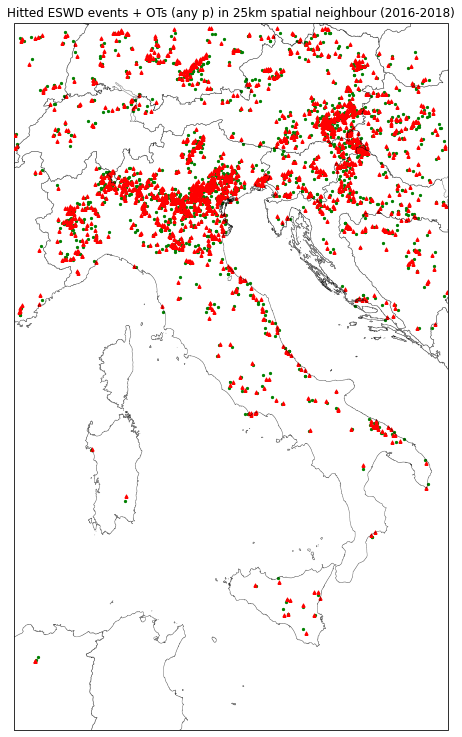

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,13), subplot_kw={'projection': ccrs.PlateCarree()})

filt_eswd_HITTED_2016_2020.plot(markersize=10, ax=ax1,figsize=(12, 8), marker='^', color='red',zorder=3)

OTset_eswdHITTED_minDtmin_2016_2020.plot(markersize=5, ax=ax1,marker='o', color='green',zorder=2)

ax1.set_ylim(y_lim)
ax1.set_xlim(x_lim)
#plt.autoscale(False)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax1, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

#gpd.GeoDataFrame(filt_eswd_MISSED_2016['geometry_25km_box'], columns=['geometry_25km_box']).rename(columns={'geometry_25km_box' : 'geometry'}).plot(ax=ax, facecolor="none", edgecolor='grey');
#gpd.GeoDataFrame(OTs_aroundMissed_eswd_2016['geometry']).plot(ax=ax,color='green')

plt.title('Hitted ESWD events + OTs (any p) in 25km spatial neighbour (2016-2020)',fontsize=12)

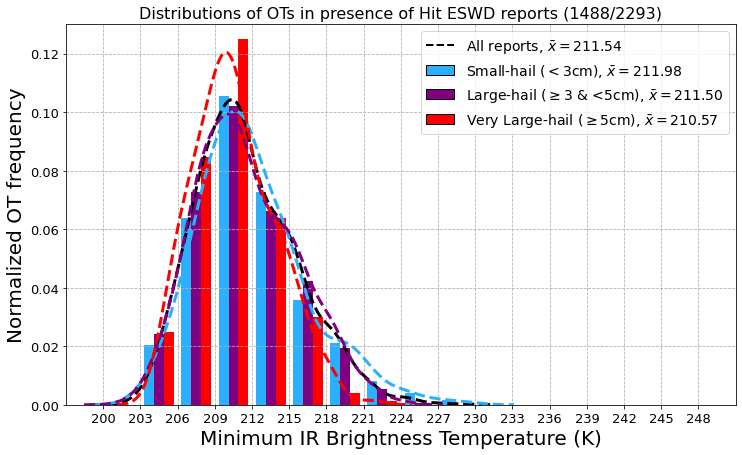

In [52]:
plt.figure(figsize=(12,7)) 

plt.hist([OTset_eswdHITTED_minIrbmin_2016_2020_small['irbmin'],
          OTset_eswdHITTED_minIrbmin_2016_2020_large['irbmin'], 
          OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['irbmin']], 
         bins=np.arange(200,250,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','red'])

sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020['irbmin'], hist=False, kde=True, 
             color = 'black', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_small['irbmin'], hist=False, kde=True, 
             color = '#2ab0ff', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_large['irbmin'], hist=False, kde=True, 
            color = 'purple', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['irbmin'], hist=False, kde=True, 
             color = 'red', kde_kws={'linewidth': 3, 'linestyle' : '--'})

plt.xticks(np.arange(200,250,3))
plt.xlim(197,251)

plt.xlabel('Minimum IR Brightness Temperature (K)', fontsize=20)

handles = [Line2D([0], [0], color='black', lw=2, ls='--'),
           Rectangle((0,0),1,1, color='#2ab0ff', ec="k"),
           Rectangle((0,0),1,1, color='purple', ec="k"),
           Rectangle((0,0),1,1, color='red', ec="k")]
labels= [r"All reports, $\bar{x} = $" + f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020['irbmin']):.2f}",
         r"Small-hail ($<3$cm), $\bar{x} = $" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_small['irbmin']):.2f}",
         r"Large-hail ($\geq 3$ & <5cm), $\bar{x} =$" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_large['irbmin']):.2f}",
         r"Very Large-hail ($\geq 5$cm), $\bar{x} =$" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['irbmin']):.2f}"]
plt.ylabel('Normalized OT frequency',fontsize=20)
plt.title('Distributions of OTs in presence of Hit ESWD reports (1488/2293)', fontsize=16)

plt.ylim([0,0.13])
plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/IrbminDtmin/IrbminHist_HITTED_ESWDFilt_smallLarge_Normalized_wDensity_2016-2020_LargeSeparated.pdf', 
#            dpi=300, bbox_inches='tight')

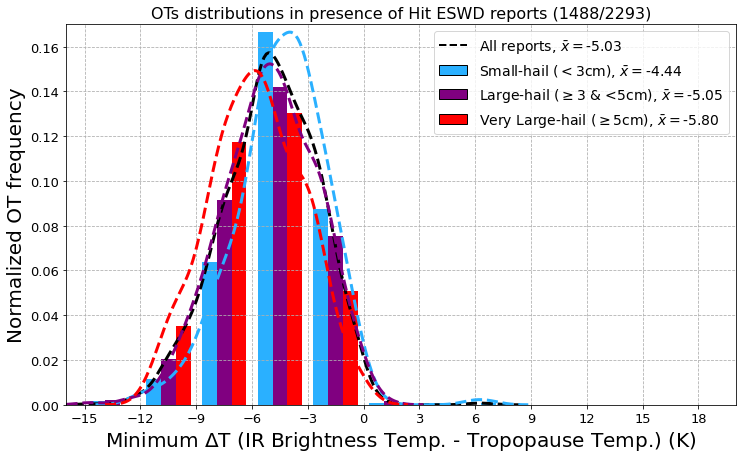

In [53]:
plt.figure(figsize=(12,7)) 

n, bins, patches = plt.hist([OTset_eswdHITTED_minIrbmin_2016_2020_small['dtmin'],
          OTset_eswdHITTED_minIrbmin_2016_2020_large['dtmin'], 
          OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['dtmin']], 
         bins=np.arange(-15,21,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','red'])

sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020['dtmin'], hist=False, kde=True, 
             color = 'black', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_small['dtmin'], hist=False, kde=True, 
             color = '#2ab0ff', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_large['dtmin'], hist=False, kde=True, 
            color = 'purple', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['dtmin'], hist=False, kde=True, 
             color = 'red', kde_kws={'linewidth': 3, 'linestyle' : '--'})

plt.xticks(np.arange(-15,21,3))
plt.xlim(-16,20)

plt.ylabel('Normalized OT frequency', fontsize=20)
plt.xlabel(r'Minimum $\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Line2D([0], [0], color='black', lw=2, ls='--'),
           Rectangle((0,0),1,1, color='#2ab0ff', ec="k"),
           Rectangle((0,0),1,1, color='purple', ec="k"),
           Rectangle((0,0),1,1, color='red', ec="k")]
labels= [r"All reports, $\bar{x} = $" + f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020['dtmin']):.2f}",
         r"Small-hail ($<3$cm), $\bar{x} = $" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_small['dtmin']):.2f}",
         r"Large-hail ($\geq 3$ & <5cm), $\bar{x} =$" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_large['dtmin']):.2f}",
         r"Very Large-hail ($\geq 5$cm), $\bar{x} =$" +f"{np.mean(OTset_eswdHITTED_minIrbmin_2016_2020_Verylarge['dtmin']):.2f}"]
plt.title('OTs distributions in presence of Hit ESWD reports (1488/2293)', fontsize=16)

plt.ylim([0,0.17])
plt.legend(handles, labels, fontsize=14, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/IrbminDtmin/DtminHist_HITTED_ESWDFilt_smallLarge_Normalized_wDensity_Largeseparated.pdf', 
#            dpi=300, bbox_inches='tight')

### - Latitudinal distribution of cloud-top temperatures

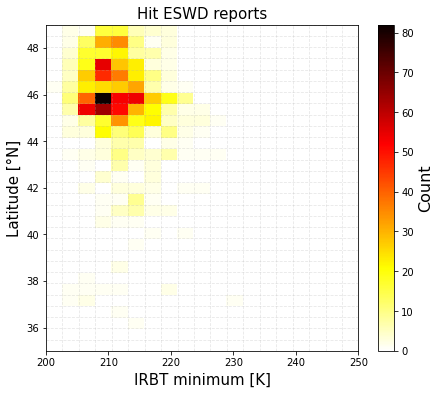

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,6))

x_bins = np.linspace(200, 250, 20)
y_bins = np.linspace(35, 49, 30)

hist1 = ax1.hist2d(OTset_eswdHITTED_minIrbmin_2016_2020['irbmin'], 
                   OTset_eswdHITTED_minIrbmin_2016_2020['lat'],
          bins=[x_bins,y_bins], 
                   cmap='hot_r')#, vmin=0, vmax=200);
plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
ax1.grid(which='minor', alpha=0.3, ls='--')
ax1.set_xticks(x_bins, minor=True)
ax1.set_yticks(y_bins, minor=True)
ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
#ax2.tick_params(labelsize=13)
ax1.set_ylabel('Latitude [°N]', fontsize=15)
ax1.set_xlabel('IRBT minimum [K]', fontsize=15)
ax1.set_title('Hit ESWD reports', fontsize=15);
#ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
#ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

In [52]:
df_HITTED = OTset_eswdHITTED_minIrbmin_2016_2020
lats = np.arange(36,49.5,0.5)

avg_IRBT_xLat_HITTED = df_HITTED['irbmin'].groupby(pd.cut(df_HITTED.lat, lats)).mean()

Text(0.5, 0, 'Latitude (°N)')

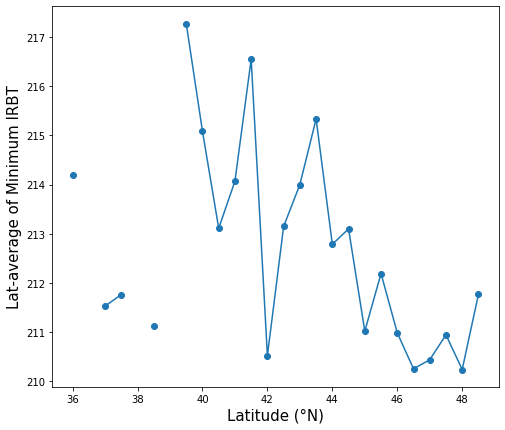

In [64]:
#Distribution of the median IRBT minimum values as a function of Latitude

fig, ax1 = plt.subplots(1, 1, figsize=(8,7))

ax1.plot(np.arange(36,49,0.5), avg_IRBT_xLat_HITTED, marker='o')
ax1.set_ylabel('Lat-average of Minimum IRBT', fontsize=15)
ax1.set_xlabel('Latitude (°N)', fontsize=15)

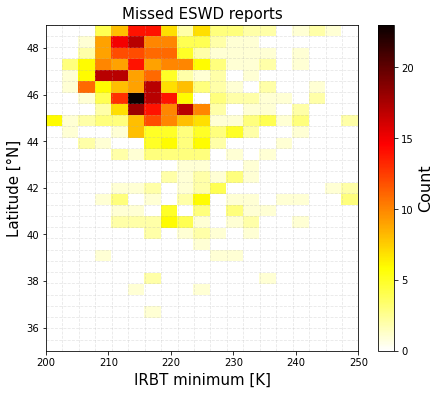

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,6))

x_bins = np.linspace(200, 250, 20)
y_bins = np.linspace(35, 49, 30)

hist1 = ax1.hist2d(OTset_eswdMISSED_minIrbmin_2016_2020['irbmin'], 
                   OTset_eswdMISSED_minIrbmin_2016_2020['lat'],
          bins=[x_bins,y_bins], 
                   cmap='hot_r')#, vmin=0, vmax=200);
plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
ax1.grid(which='minor', alpha=0.3, ls='--')
ax1.set_xticks(x_bins, minor=True)
ax1.set_yticks(y_bins, minor=True)
ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
#ax2.tick_params(labelsize=13)
ax1.set_ylabel('Latitude [°N]', fontsize=15)
ax1.set_xlabel('IRBT minimum [K]', fontsize=15)
ax1.set_title('Missed ESWD reports', fontsize=15);
#ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
#ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

In [72]:
df_MISSED = OTset_eswdMISSED_minIrbmin_2016_2020
lats = np.arange(36,49.5,0.5)

avg_IRBT_xLat_MISSED = df_MISSED['irbmin'].groupby(pd.cut(df_MISSED.lat, lats)).mean()

Text(0.5, 0, 'Latitude (°N)')

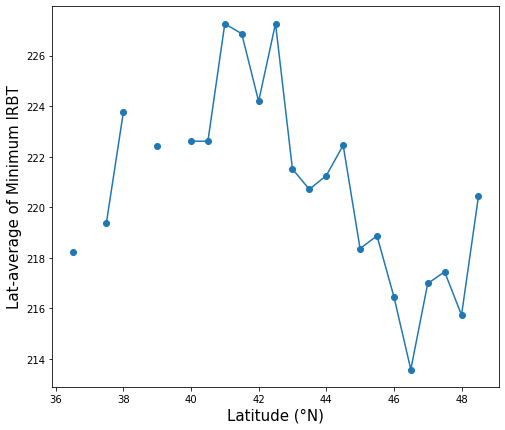

In [73]:
#Distribution of the median IRBT minimum values as a function of Latitude

fig, ax1 = plt.subplots(1, 1, figsize=(8,7))

ax1.plot(np.arange(36,49,0.5), avg_IRBT_xLat_MISSED, marker='o')
ax1.set_ylabel('Lat-average of Minimum IRBT', fontsize=15)
ax1.set_xlabel('Latitude (°N)', fontsize=15)

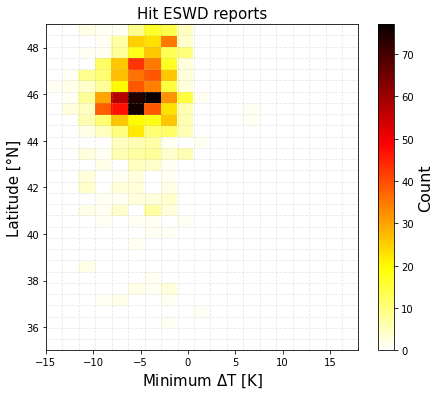

In [76]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,6))

x_bins = np.linspace(-15, 18, 20)
y_bins = np.linspace(35, 49, 30)

hist1 = ax1.hist2d(OTset_eswdHITTED_minIrbmin_2016_2020['dtmin'], 
                   OTset_eswdHITTED_minIrbmin_2016_2020['lat'],
          bins=[x_bins,y_bins], 
                   cmap='hot_r')#, vmin=0, vmax=200);
plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
ax1.grid(which='minor', alpha=0.3, ls='--')
ax1.set_xticks(x_bins, minor=True)
ax1.set_yticks(y_bins, minor=True)
ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
#ax2.tick_params(labelsize=13)
ax1.set_ylabel('Latitude [°N]', fontsize=15)
ax1.set_xlabel('Minimum $\Delta$T [K]', fontsize=15)
ax1.set_title('Hit ESWD reports', fontsize=15);
#ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
#ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

In [80]:
avg_DT_xLat_HITTED = df_HITTED['dtmin'].groupby(pd.cut(df_HITTED.lat, lats)).mean()

Text(0.5, 0, 'Latitude (°N)')

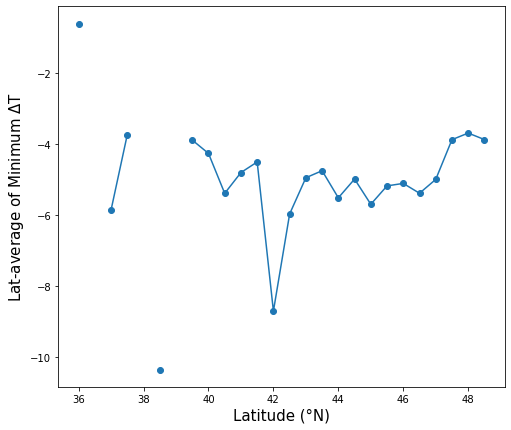

In [81]:
#Distribution of the median IRBT minimum values as a function of Latitude

fig, ax1 = plt.subplots(1, 1, figsize=(8,7))

ax1.plot(np.arange(36,49,0.5), avg_DT_xLat_HITTED, marker='o')
ax1.set_ylabel('Lat-average of Minimum $\Delta$T', fontsize=15)
ax1.set_xlabel('Latitude (°N)', fontsize=15)

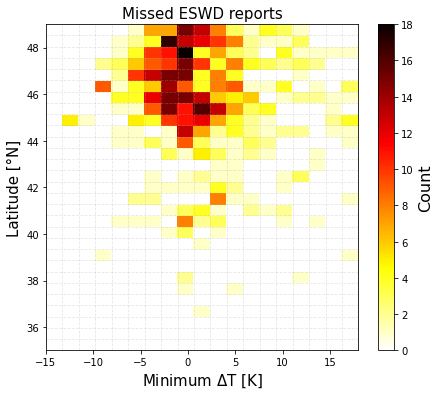

In [75]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,6))

x_bins = np.linspace(-15, 18, 20)
y_bins = np.linspace(35, 49, 30)

hist1 = ax1.hist2d(OTset_eswdMISSED_minIrbmin_2016_2020['dtmin'], 
                   OTset_eswdMISSED_minIrbmin_2016_2020['lat'],
          bins=[x_bins,y_bins], 
                   cmap='hot_r')#, vmin=0, vmax=200);
plt.colorbar(hist1[3], ax=ax1).set_label(label='Count',size=16)
ax1.grid(which='minor', alpha=0.3, ls='--')
ax1.set_xticks(x_bins, minor=True)
ax1.set_yticks(y_bins, minor=True)
ax1.tick_params(axis='both', which='minor', bottom=False, left=False, labelbottom=False)
#ax2.tick_params(labelsize=13)
ax1.set_ylabel('Latitude [°N]', fontsize=15)
ax1.set_xlabel('Minimum $\Delta$T [K]', fontsize=15)
ax1.set_title('Missed ESWD reports', fontsize=15);
#ax1.axvline(x=x_thresh, lw=0.75, linestyle=':', color='green')
#ax1.axhline(y=y_thresh, lw=0.75, linestyle=':', color='green')

In [82]:
avg_DT_xLat_MISSED = df_MISSED['dtmin'].groupby(pd.cut(df_MISSED.lat, lats)).mean()

Text(0.5, 0, 'Latitude (°N)')

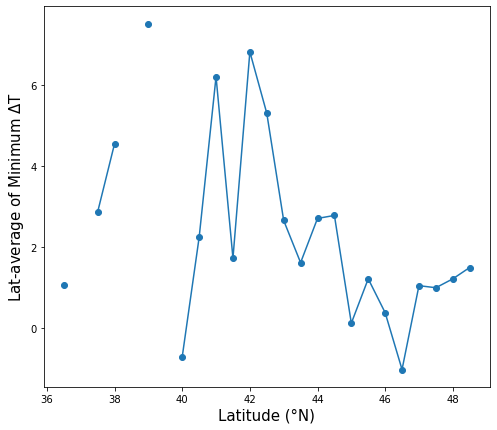

In [83]:
#Distribution of the median IRBT minimum values as a function of Latitude

fig, ax1 = plt.subplots(1, 1, figsize=(8,7))

ax1.plot(np.arange(36,49,0.5), avg_DT_xLat_MISSED, marker='o')
ax1.set_ylabel('Lat-average of Minimum $\Delta$T', fontsize=15)
ax1.set_xlabel('Latitude (°N)', fontsize=15)

### - MISSED eswd analysis with spatial aggregation of DTmin and IRBmin (without otpmax constraint!)

In [67]:
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2016_minDtmin.txt', 'rb') as file:
     OTset_eswdMISSED_2016_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2016_minIrbmin.txt', 'rb') as file:
     OTset_eswdMISSED_2016_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2017_minDtmin.txt', 'rb') as file:
     OTset_eswdMISSED_2017_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2017_minIrbmin.txt', 'rb') as file:
     OTset_eswdMISSED_2017_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2018_minDtmin.txt', 'rb') as file:
     OTset_eswdMISSED_2018_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2018_minIrbmin.txt', 'rb') as file:
     OTset_eswdMISSED_2018_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2019_minDtmin.txt', 'rb') as file:
     OTset_eswdMISSED_2019_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2019_minIrbmin.txt', 'rb') as file:
     OTset_eswdMISSED_2019_minIrbmin = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2020_minDtmin.txt', 'rb') as file:
     OTset_eswdMISSED_2020_minDtmin = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/SpatAggregated_2016-2020/MISSEDeswd_allOtpmax/2020_minIrbmin.txt', 'rb') as file:
     OTset_eswdMISSED_2020_minIrbmin = pickle.load(file)

In [68]:
#concat together:
OTset_eswdMISSED_minDtmin_2016_2020 = pd.concat([OTset_eswdMISSED_2016_minDtmin,OTset_eswdMISSED_2017_minDtmin,
                                             OTset_eswdMISSED_2018_minDtmin,OTset_eswdMISSED_2019_minDtmin,
                                                OTset_eswdMISSED_2020_minDtmin])
OTset_eswdMISSED_minIrbmin_2016_2020 = pd.concat([OTset_eswdMISSED_2016_minIrbmin,OTset_eswdMISSED_2017_minIrbmin,
                                             OTset_eswdMISSED_2018_minIrbmin, OTset_eswdMISSED_2019_minIrbmin,
                                                 OTset_eswdMISSED_2020_minIrbmin])

In [69]:
#RIMUOVERE DOPPIONI DAI DATASET!!!!!!!!!!
OTset_eswdMISSED_minDtmin_2016_2020 = OTset_eswdMISSED_minDtmin_2016_2020.drop_duplicates()
OTset_eswdMISSED_minIrbmin_2016_2020 = OTset_eswdMISSED_minIrbmin_2016_2020.drop_duplicates()

In [70]:
#SMALL HAIL (<3cm)
OTset_eswdMISSED_minDtmin_2016_2020_small = OTset_eswdMISSED_minDtmin_2016_2020[
    OTset_eswdMISSED_minDtmin_2016_2020['hail_size'] < 3]
OTset_eswdMISSED_minIrbmin_2016_2020_small = OTset_eswdMISSED_minIrbmin_2016_2020[
    OTset_eswdMISSED_minIrbmin_2016_2020['hail_size'] < 3]

#LARGE HAIL (>=3cm)
OTset_eswdMISSED_minDtmin_2016_2020_large = OTset_eswdMISSED_minDtmin_2016_2020[
    (OTset_eswdMISSED_minDtmin_2016_2020['hail_size'] >= 3) & (OTset_eswdMISSED_minDtmin_2016_2020['hail_size'] <5)]
OTset_eswdMISSED_minIrbmin_2016_2020_large = OTset_eswdMISSED_minIrbmin_2016_2020[
    (OTset_eswdMISSED_minIrbmin_2016_2020['hail_size'] >= 3) & (OTset_eswdMISSED_minIrbmin_2016_2020['hail_size'] <5)]

#VERY LARGE HAIL (>=5cm)
OTset_eswdMISSED_minDtmin_2016_2020_Verylarge = OTset_eswdMISSED_minDtmin_2016_2020[
    OTset_eswdMISSED_minDtmin_2016_2020['hail_size'] >= 5]
OTset_eswdMISSED_minIrbmin_2016_2020_Verylarge = OTset_eswdMISSED_minIrbmin_2016_2020[
    OTset_eswdMISSED_minIrbmin_2016_2020['hail_size'] >= 5]

Text(0.5, 1.0, 'Missed ESWD events + OTs (any p) in 25km spatial neighbour (2016-2020)')

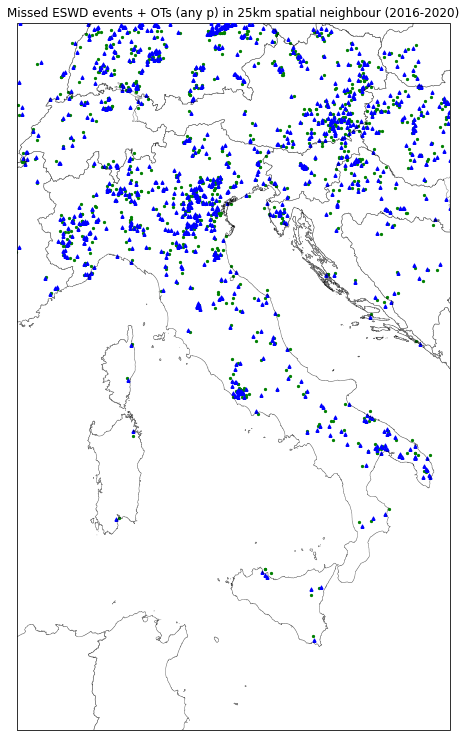

In [38]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,13), subplot_kw={'projection': ccrs.PlateCarree()})

filt_eswd_MISSED_2016_2020.plot(markersize=10, ax=ax1,figsize=(12, 8), marker='^', color='blue',zorder=3)

OTset_eswdMISSED_minDtmin_2016_2020.plot(markersize=5, ax=ax1,marker='o', color='green',zorder=2)

ax1.set_ylim(y_lim)
ax1.set_xlim(x_lim)
#plt.autoscale(False)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax1, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

#gpd.GeoDataFrame(filt_eswd_MISSED_2016['geometry_25km_box'], columns=['geometry_25km_box']).rename(columns={'geometry_25km_box' : 'geometry'}).plot(ax=ax, facecolor="none", edgecolor='grey');
#gpd.GeoDataFrame(OTs_aroundMissed_eswd_2016['geometry']).plot(ax=ax,color='green')

plt.title('Missed ESWD events + OTs (any p) in 25km spatial neighbour (2016-2020)',fontsize=12)


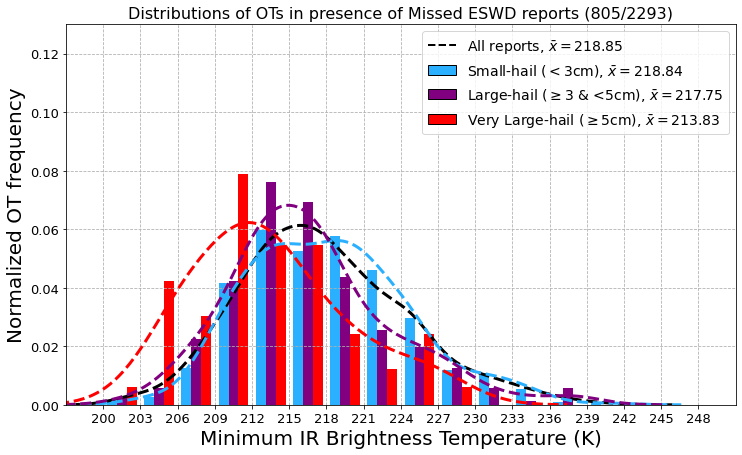

In [60]:
plt.figure(figsize=(12,7)) 

plt.hist([OTset_eswdMISSED_minDtmin_2016_2020_small['irbmin'],
          OTset_eswdMISSED_minDtmin_2016_2020_large['irbmin'], 
          OTset_eswdMISSED_minDtmin_2016_2020_Verylarge['irbmin']], 
         bins=np.arange(200,250,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','red'])

sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020['irbmin'], hist=False, kde=True, 
             color = 'black', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_small['irbmin'], hist=False, kde=True, 
             color = '#2ab0ff', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_large['irbmin'], hist=False, kde=True, 
            color = 'purple', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_Verylarge['irbmin'], hist=False, kde=True, 
             color = 'red', kde_kws={'linewidth': 3, 'linestyle' : '--'})

plt.xticks(np.arange(200,250,3))
plt.xlim(197,251)

plt.xlabel('Minimum IR Brightness Temperature (K)', fontsize=20)

handles = [Line2D([0], [0], color='black', lw=2, ls='--'),
           Rectangle((0,0),1,1, color='#2ab0ff', ec="k"),
           Rectangle((0,0),1,1, color='purple', ec="k"),
           Rectangle((0,0),1,1, color='red', ec="k")]
labels= [r"All reports, $\bar{x} = $" + f"{np.mean(OTset_eswdMISSED_minIrbmin_2016_2020['irbmin']):.2f}",
         r"Small-hail ($<3$cm), $\bar{x} = $" +f"{np.mean(OTset_eswdMISSED_minIrbmin_2016_2020_small['irbmin']):.2f}",
         r"Large-hail ($\geq 3$ & <5cm), $\bar{x} =$" +f"{np.mean(OTset_eswdMISSED_minIrbmin_2016_2020_large['irbmin']):.2f}",
         r"Very Large-hail ($\geq 5$cm), $\bar{x} =$" +f"{np.mean(OTset_eswdMISSED_minIrbmin_2016_2020_Verylarge['irbmin']):.2f}"]
plt.ylabel('Normalized OT frequency',fontsize=20)
plt.title('Distributions of OTs in presence of Missed ESWD reports (805/2293)', fontsize=16)

plt.ylim([0,0.13])
plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/IrbminDtmin/IrbminHist_MissedESWDFilt_smallLarge_Normalized_wDensity_Largeseparated.pdf', 
#            dpi=300, bbox_inches='tight')

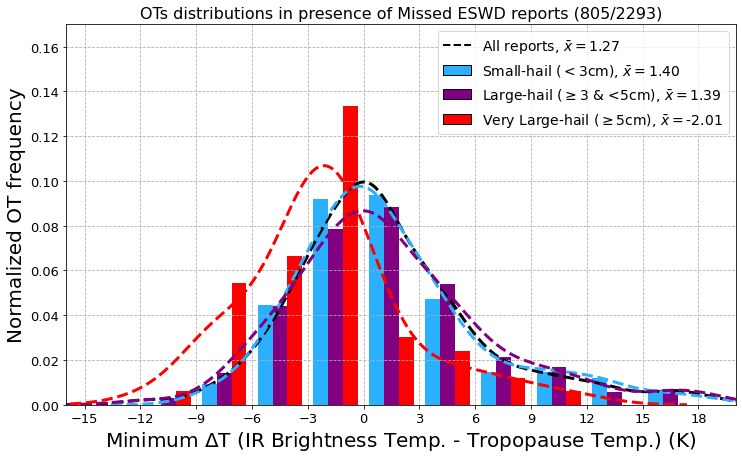

In [61]:
plt.figure(figsize=(12,7)) 

n, bins, patches = plt.hist([OTset_eswdMISSED_minDtmin_2016_2020_small['dtmin'],
          OTset_eswdMISSED_minDtmin_2016_2020_large['dtmin'], 
          OTset_eswdMISSED_minDtmin_2016_2020_Verylarge['dtmin']], 
         bins=np.arange(-15,21,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','red'])

sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020['dtmin'], hist=False, kde=True, 
             color = 'black', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_small['dtmin'], hist=False, kde=True, 
             color = '#2ab0ff', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_large['dtmin'], hist=False, kde=True, 
            color = 'purple', kde_kws={'linewidth': 3, 'linestyle' : '--'})
sns.distplot(OTset_eswdMISSED_minDtmin_2016_2020_Verylarge['dtmin'], hist=False, kde=True, 
             color = 'red', kde_kws={'linewidth': 3, 'linestyle' : '--'})

plt.xticks(np.arange(-15,21,3))
plt.xlim(-16,20)

plt.ylabel('Normalized OT frequency', fontsize=20)
plt.xlabel(r'Minimum $\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Line2D([0], [0], color='black', lw=2, ls='--'),
           Rectangle((0,0),1,1, color='#2ab0ff', ec="k"),
           Rectangle((0,0),1,1, color='purple', ec="k"),
           Rectangle((0,0),1,1, color='red', ec="k")]
labels= [r"All reports, $\bar{x} = $" + f"{np.mean(OTset_eswdMISSED_minDtmin_2016_2020['dtmin']):.2f}",
         r"Small-hail ($<3$cm), $\bar{x} = $" +f"{np.mean(OTset_eswdMISSED_minDtmin_2016_2020_small['dtmin']):.2f}",
         r"Large-hail ($\geq 3$ & <5cm), $\bar{x} =$" +f"{np.mean(OTset_eswdMISSED_minDtmin_2016_2020_large['dtmin']):.2f}",
         r"Very Large-hail ($\geq 5$cm), $\bar{x} =$" +f"{np.mean(OTset_eswdMISSED_minDtmin_2016_2020_Verylarge['dtmin']):.2f}"]
plt.title('OTs distributions in presence of Missed ESWD reports (805/2293)', fontsize=16)

plt.ylim([0,0.17])
plt.legend(handles, labels, fontsize=14, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

#plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots_2016-2020_FULL/AmbientCharact/IrbminDtmin/dtminHist_MissedESWDFilt_smallLarge_Normalized_wDensity_Largeseparated.pdf', 
#            dpi=300, bbox_inches='tight')